# Part 4: Classification

In this notebook, we will exploit quantitative measurements in order to retreive different phenotypic groups present in a large image dataset. The end goal will be to group samples (whether full images or individual objects) into different classes, a process referred to as *classification*. We will here review commonly-used (non-deep-learning) strategies for classification.

In [1]:
import os
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200

In this part, we will use pandas to handle numerical data (https://pandas.pydata.org/) and seaborn to generate cute plots (). Feel free to consult the extensive documentation available on their websites if you want to know more about these libraries!

In [2]:
import pandas as pd
import seaborn as sb

## 1. Data loading

Following on what we did in notebook 3 - Quantification, we will again work with feature matrices extracted from the BBBC010 dataset featuring dead and live *C. elegans* worms. 

**1.1** Run the lines below to load and display the feature matrix for the entire BBBC010 dataset. Note that features are here reported *per-image*: they correspond to the average value of any given feature across all instances present in the image.

In [3]:
bbbc010_img_feats = pd.read_csv('data/Part 4/BBBC010/bbbc010_image_features.csv')
bbbc010_img_feats.set_index('image_id', inplace = True)

display(bbbc010_img_feats)

,area,area_bbox,area_convex,area_filled,axis_major_length,axis_minor_length,eccentricity,equivalent_diameter_area,euler_number,extent,...,moments_weighted_hu-2,moments_weighted_hu-3,moments_weighted_hu-4,moments_weighted_hu-5,moments_weighted_hu-6,perimeter,perimeter_crofton,solidity,inertia_tensor_eigvals-0,inertia_tensor_eigvals-1
image_id,,,,,,,,,,,,,,,,,,,,,
B19,943.0,4108.5,1106.0,943.0,123.570549,10.548067,0.996573,34.650125,1.0,0.228990,...,7588.008983,5412.063805,3.628178e+07,3.696531e+05,-244015.600002,247.959938,238.056804,0.849288,955.418213,6.961393
C08,992.0,4017.0,2320.0,992.0,105.018978,31.627365,0.962186,35.539466,1.0,0.270981,...,31037.408386,6120.538317,4.518897e+06,6.949827e+04,131317.931469,261.036580,250.159713,0.474510,689.311608,62.518137
A19,1007.0,5570.0,1256.0,1007.0,132.804181,10.995167,0.996344,35.805206,1.0,0.194813,...,9226.734523,6673.665822,4.696403e+07,4.239094e+05,-1899.335729,265.282792,256.847158,0.812467,1102.317839,7.557020
A17,1003.5,3452.0,1205.0,1003.5,130.924845,10.653125,0.996696,35.744738,1.0,0.256726,...,11922.301041,9432.248373,1.098919e+08,7.028946e+05,-7180.150784,267.734542,257.081984,0.834433,1071.545636,7.093067
C14,986.0,7068.0,1223.0,986.0,132.262768,10.362722,0.996913,35.431825,1.0,0.133833,...,58065.858521,39343.463171,1.872940e+09,2.767755e+06,102463.455280,266.960461,255.775905,0.833582,1093.339988,6.711625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D17,992.0,2640.0,1229.0,992.0,128.188235,10.288765,0.996859,35.539466,1.0,0.317766,...,58537.926367,55776.638663,3.187109e+09,4.670525e+06,35678.848885,257.154329,255.864418,0.817810,1027.013969,6.616168
D14,976.0,4068.0,1138.0,976.0,125.830275,10.531605,0.996413,35.251692,1.0,0.249263,...,4838.434642,2703.017315,5.447706e+06,1.222994e+05,33613.441270,253.303607,242.828395,0.849762,989.578625,6.932169
A23,1005.5,4443.0,1209.0,1005.5,132.000311,10.698218,0.996587,35.778792,1.0,0.252010,...,21727.929175,15534.741409,2.650161e+08,9.351359e+05,3827.231079,273.320328,264.756956,0.839605,1089.018195,7.153789


**1.2** As you may have noticed when inspecting the feature matrix above, different features have very different range of values. To make sure features with higher values do not "overwhelm" features with lower values, it is useful to first rescale them all into the [0, 1] range. Run the lines below to carry this out.

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
scaler = MinMaxScaler()
bbbc010_img_feats[:] = scaler.fit_transform(bbbc010_img_feats[:])

display(bbbc010_img_feats)

,area,area_bbox,area_convex,area_filled,axis_major_length,axis_minor_length,eccentricity,equivalent_diameter_area,euler_number,extent,...,moments_weighted_hu-2,moments_weighted_hu-3,moments_weighted_hu-4,moments_weighted_hu-5,moments_weighted_hu-6,perimeter,perimeter_crofton,solidity,inertia_tensor_eigvals-0,inertia_tensor_eigvals-1
image_id,,,,,,,,,,,,,,,,,,,,,
B19,0.306773,0.331640,0.055460,0.306773,0.691083,0.047194,0.988211,0.320506,0.0,0.501403,...,0.015428,0.018037,0.000912,0.015997,0.371475,0.147084,0.137561,0.943267,0.657869,0.020683
C08,0.501992,0.310976,0.886683,0.501992,0.206172,0.831038,0.484575,0.517858,0.0,0.718995,...,0.117010,0.021181,0.000305,0.005551,0.377624,0.537745,0.515360,0.056196,0.179243,0.747957
A19,0.561753,0.661698,0.158165,0.561753,0.932437,0.063820,0.984846,0.576828,0.0,0.324302,...,0.022527,0.023635,0.001116,0.017885,0.375441,0.664600,0.724113,0.856114,0.922086,0.028480
A17,0.547809,0.183379,0.123245,0.547809,0.883314,0.051101,0.990001,0.563409,0.0,0.645128,...,0.034204,0.035874,0.002318,0.027594,0.375355,0.737845,0.731443,0.908107,0.866739,0.022407
C14,0.478088,1.000000,0.135570,0.478088,0.918285,0.040302,0.993189,0.493971,0.0,0.008313,...,0.234095,0.168581,0.036006,0.099456,0.377151,0.714720,0.690673,0.906092,0.905939,0.017414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D17,0.501992,0.000000,0.139678,0.501992,0.811782,0.037552,0.992391,0.517858,0.0,0.961426,...,0.236140,0.241491,0.061117,0.165676,0.376057,0.421764,0.693436,0.868760,0.786643,0.016164
D14,0.438247,0.322493,0.077371,0.438247,0.750149,0.046582,0.985856,0.453998,0.0,0.606453,...,0.003517,0.006018,0.000323,0.007388,0.376023,0.306725,0.286509,0.944388,0.719311,0.020301
A23,0.555777,0.407182,0.125984,0.555777,0.911425,0.052778,0.988419,0.570966,0.0,0.620689,...,0.076682,0.062949,0.005282,0.035677,0.375535,0.904719,0.971022,0.920348,0.898165,0.023202


**1.3** In order to evaluate the quality of our classification attempts, we need a ground truth to compare to. Run the lines below to load and display the ground truth label for each image in the dataset.

In [6]:
bbbc010_img_gt = pd.read_csv('data/Part 4/BBBC010/bbbc010_image_ground_truth.csv')
bbbc010_img_gt.set_index('image_id', inplace = True)

display(bbbc010_img_gt)

,label
image_id,
A01,live
A02,live
A03,live
A04,live
A05,live
...,...
D24,dead
E01,live
E02,live


**1.4** To simplify processing later on, it is useful to have a "labelled" version of the feature matrix. Run the lines below to merge the feature matrix and the ground truth labels into a single data frame.

In [7]:
bbbc010_img = bbbc010_img_feats.join(bbbc010_img_gt)

display(bbbc010_img)

,area,area_bbox,area_convex,area_filled,axis_major_length,axis_minor_length,eccentricity,equivalent_diameter_area,euler_number,extent,...,moments_weighted_hu-3,moments_weighted_hu-4,moments_weighted_hu-5,moments_weighted_hu-6,perimeter,perimeter_crofton,solidity,inertia_tensor_eigvals-0,inertia_tensor_eigvals-1,label
image_id,,,,,,,,,,,,,,,,,,,,,
B19,0.306773,0.331640,0.055460,0.306773,0.691083,0.047194,0.988211,0.320506,0.0,0.501403,...,0.018037,0.000912,0.015997,0.371475,0.147084,0.137561,0.943267,0.657869,0.020683,dead
C08,0.501992,0.310976,0.886683,0.501992,0.206172,0.831038,0.484575,0.517858,0.0,0.718995,...,0.021181,0.000305,0.005551,0.377624,0.537745,0.515360,0.056196,0.179243,0.747957,live
A19,0.561753,0.661698,0.158165,0.561753,0.932437,0.063820,0.984846,0.576828,0.0,0.324302,...,0.023635,0.001116,0.017885,0.375441,0.664600,0.724113,0.856114,0.922086,0.028480,dead
A17,0.547809,0.183379,0.123245,0.547809,0.883314,0.051101,0.990001,0.563409,0.0,0.645128,...,0.035874,0.002318,0.027594,0.375355,0.737845,0.731443,0.908107,0.866739,0.022407,dead
C14,0.478088,1.000000,0.135570,0.478088,0.918285,0.040302,0.993189,0.493971,0.0,0.008313,...,0.168581,0.036006,0.099456,0.377151,0.714720,0.690673,0.906092,0.905939,0.017414,dead
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D17,0.501992,0.000000,0.139678,0.501992,0.811782,0.037552,0.992391,0.517858,0.0,0.961426,...,0.241491,0.061117,0.165676,0.376057,0.421764,0.693436,0.868760,0.786643,0.016164,dead
D14,0.438247,0.322493,0.077371,0.438247,0.750149,0.046582,0.985856,0.453998,0.0,0.606453,...,0.006018,0.000323,0.007388,0.376023,0.306725,0.286509,0.944388,0.719311,0.020301,dead
A23,0.555777,0.407182,0.125984,0.555777,0.911425,0.052778,0.988419,0.570966,0.0,0.620689,...,0.062949,0.005282,0.035677,0.375535,0.904719,0.971022,0.920348,0.898165,0.023202,dead


## 2. Feature selection and dimensionality reduction

As we have seen in notebook 3- Quantification, it is hard to find a single feature able to discriminate between dead and live worms. The feature matrix we are working with has thus been built by putting together an extensive collection of 33 measurements capturing shape and intensity, in the hope that all of these features considered together can capture the difference between the 'dead' and 'live' phenotypes. 

While it is clear that more than a single feature is needed, some of the features may however be more informative than others. Among the 33 features considered, some may in fact be entirely uninformative. Revealing which features are relevant and which aren't and making sure that our feature matrix is not too redundant is the job of feature selection and dimensionality reduction methods, as we shall see now.

**2.1** In order to get a first impression of whether each of the feature in our matrix is informative, we can investigate their distributions, for instance by looking at violin plots produced by running the lines below. We know that our dataset is composed of two classes (dead and live), and are therefore mostly interested in features that have a bimodal distribution. Can you spot features that seem to be uninformative?

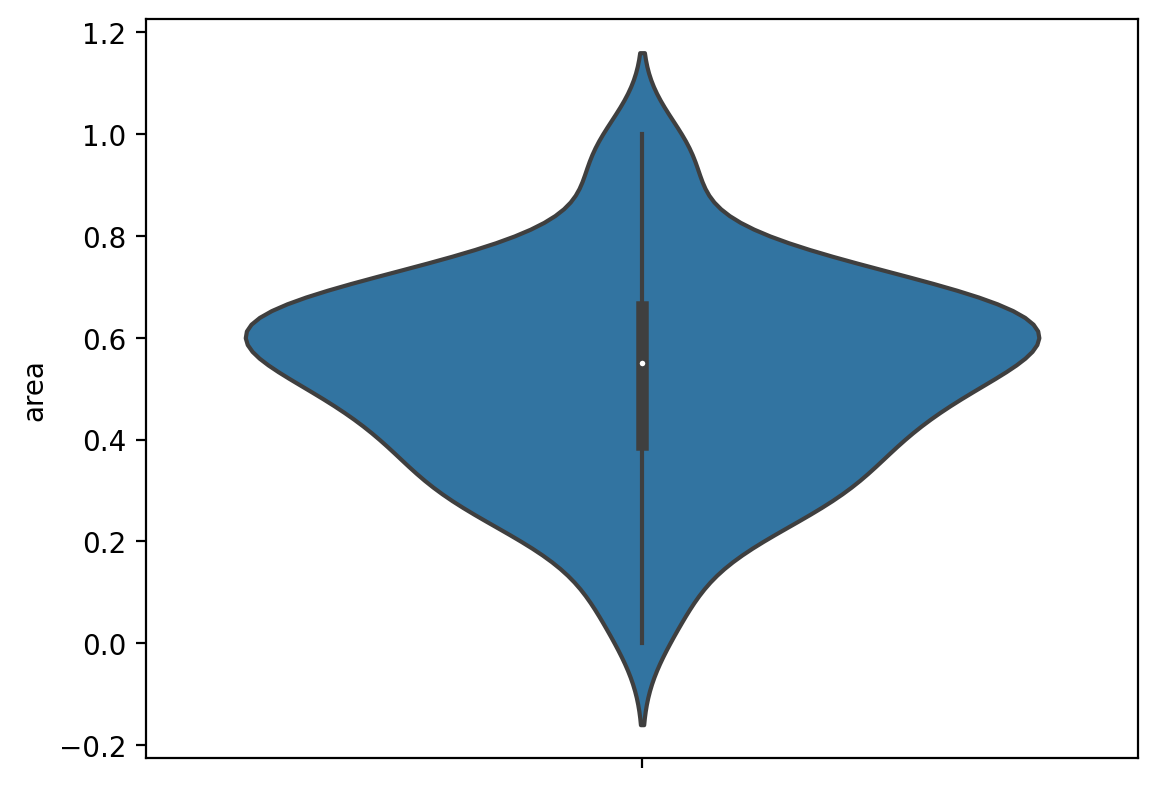

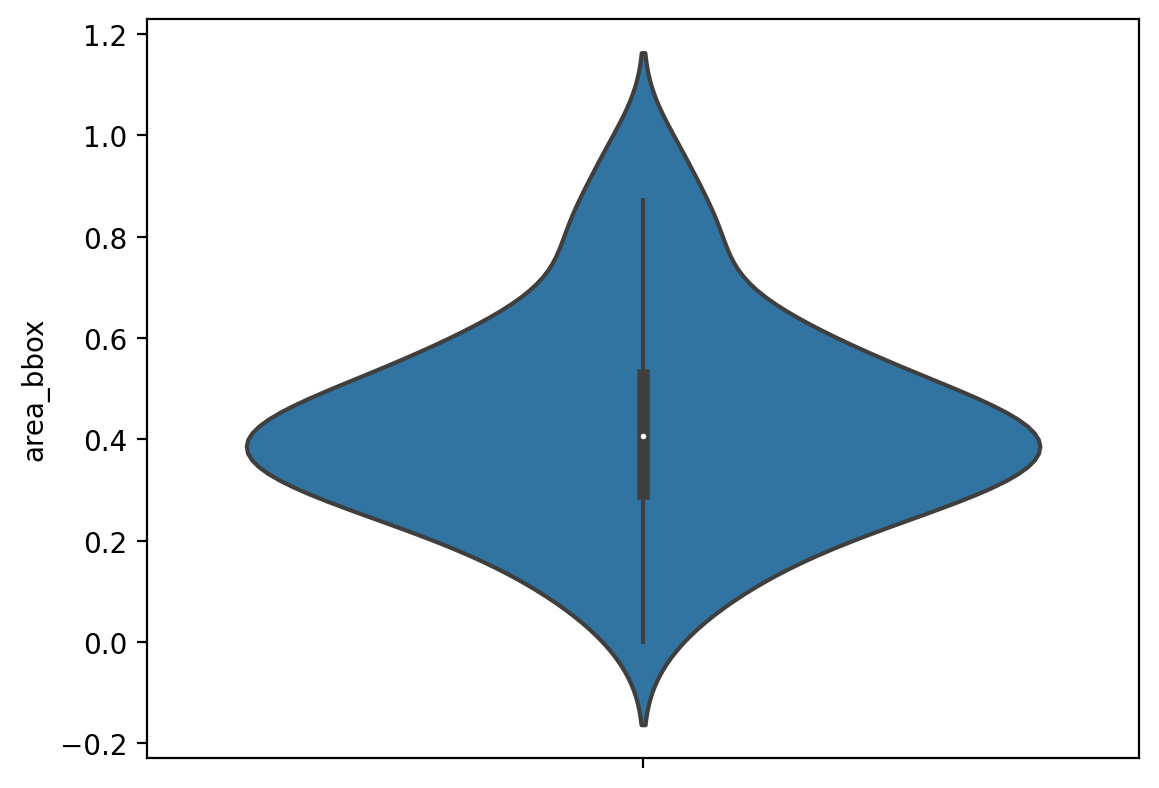

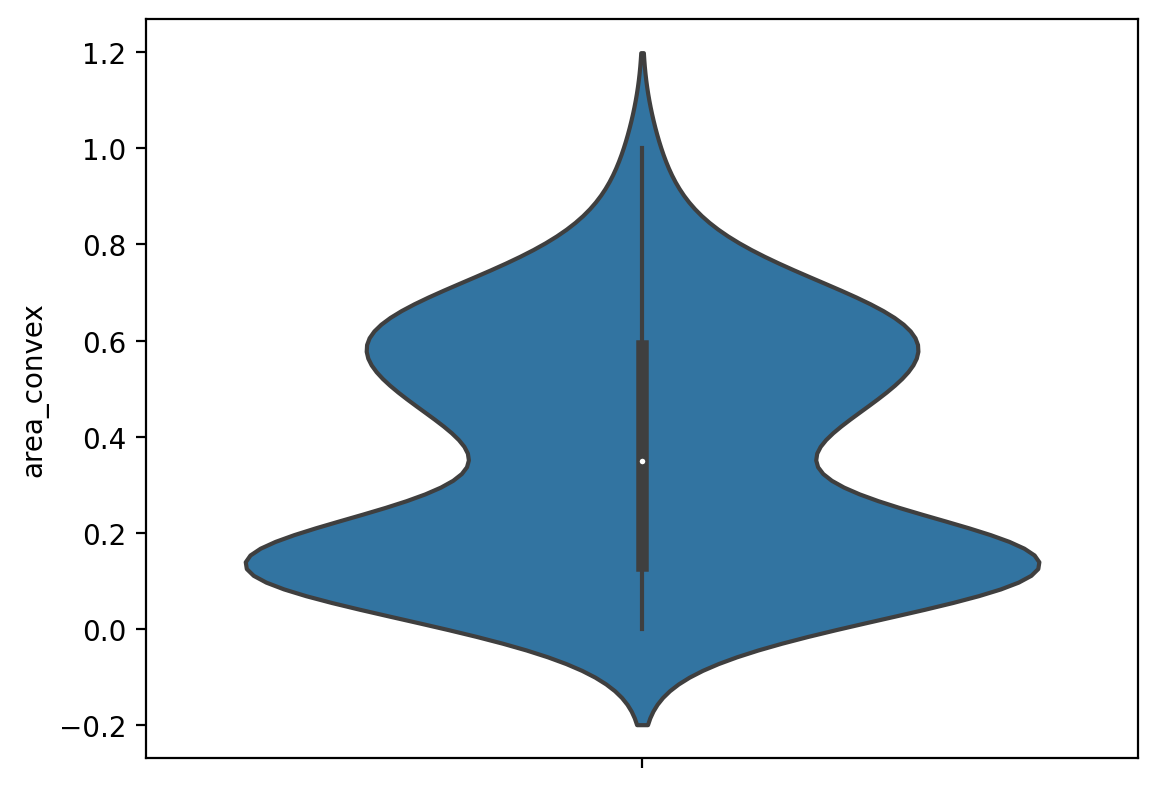

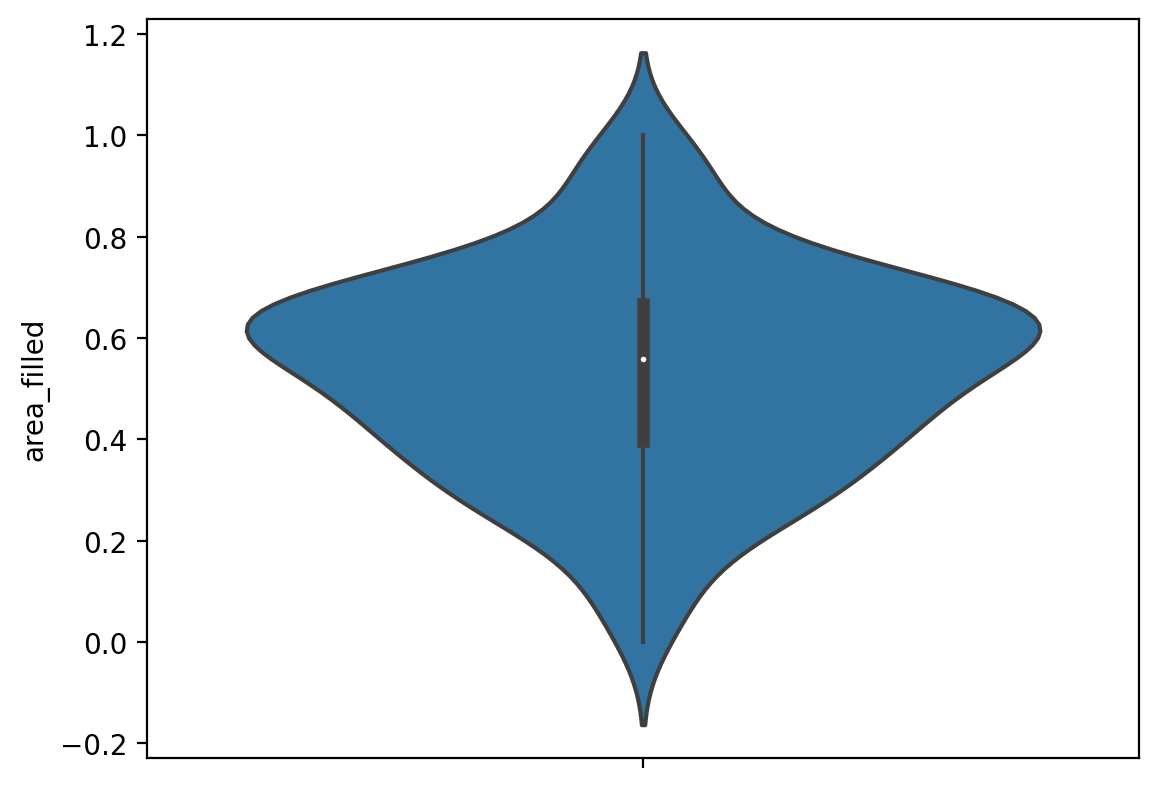

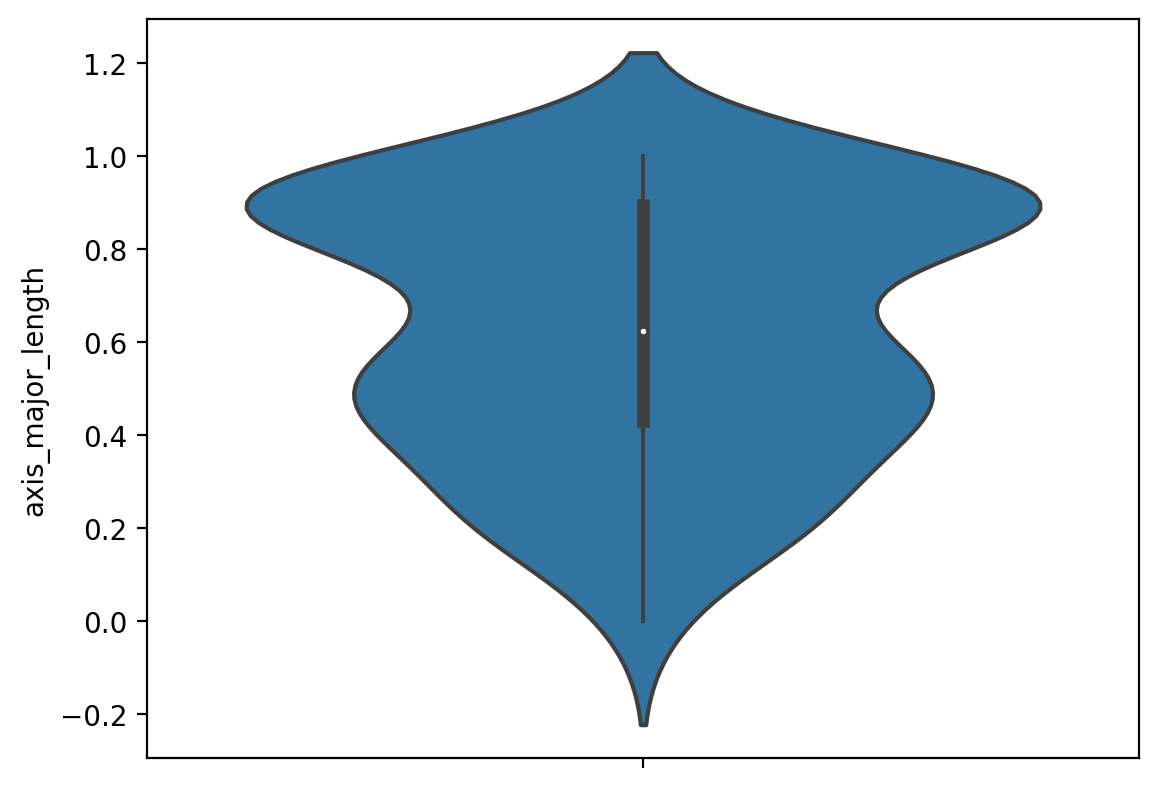

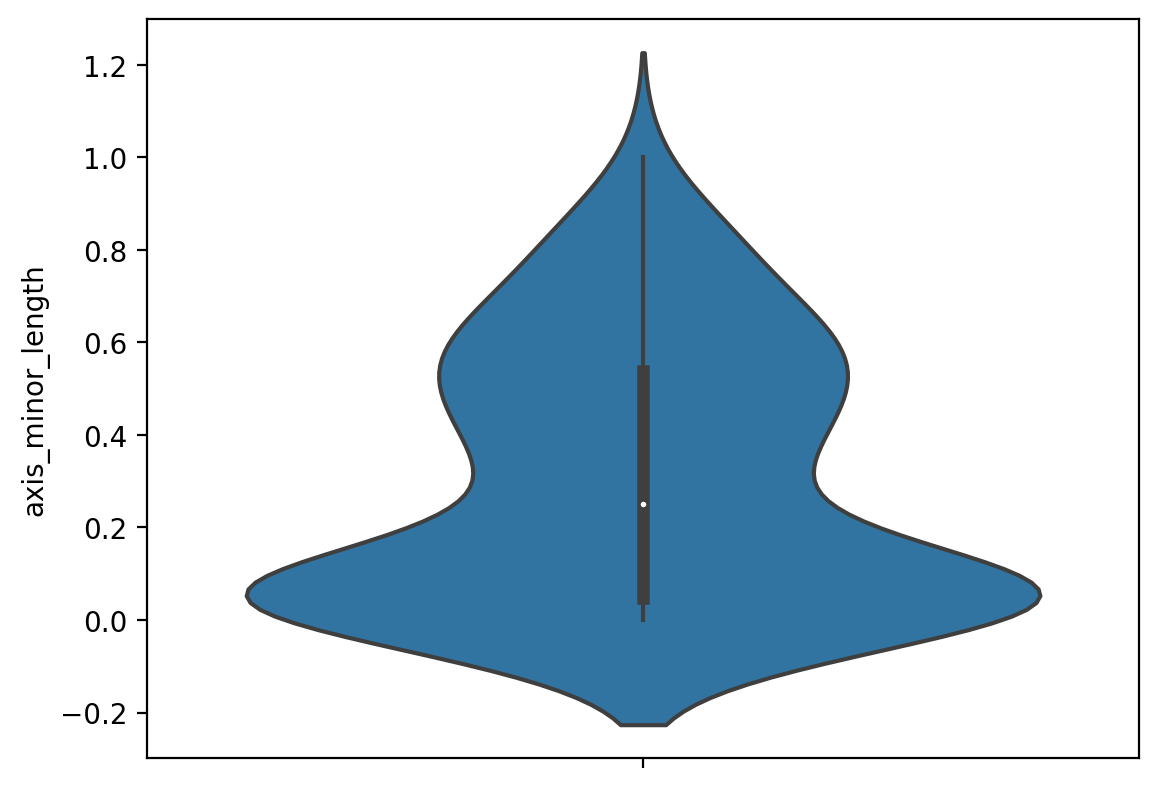

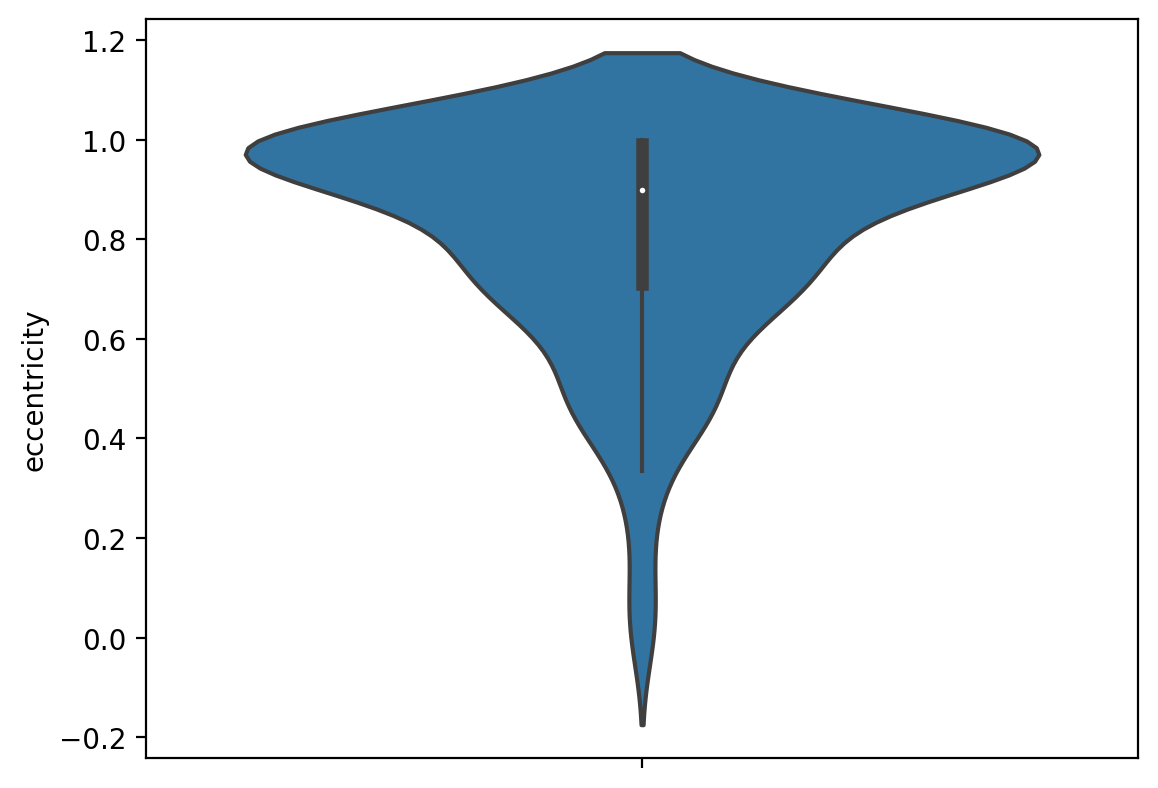

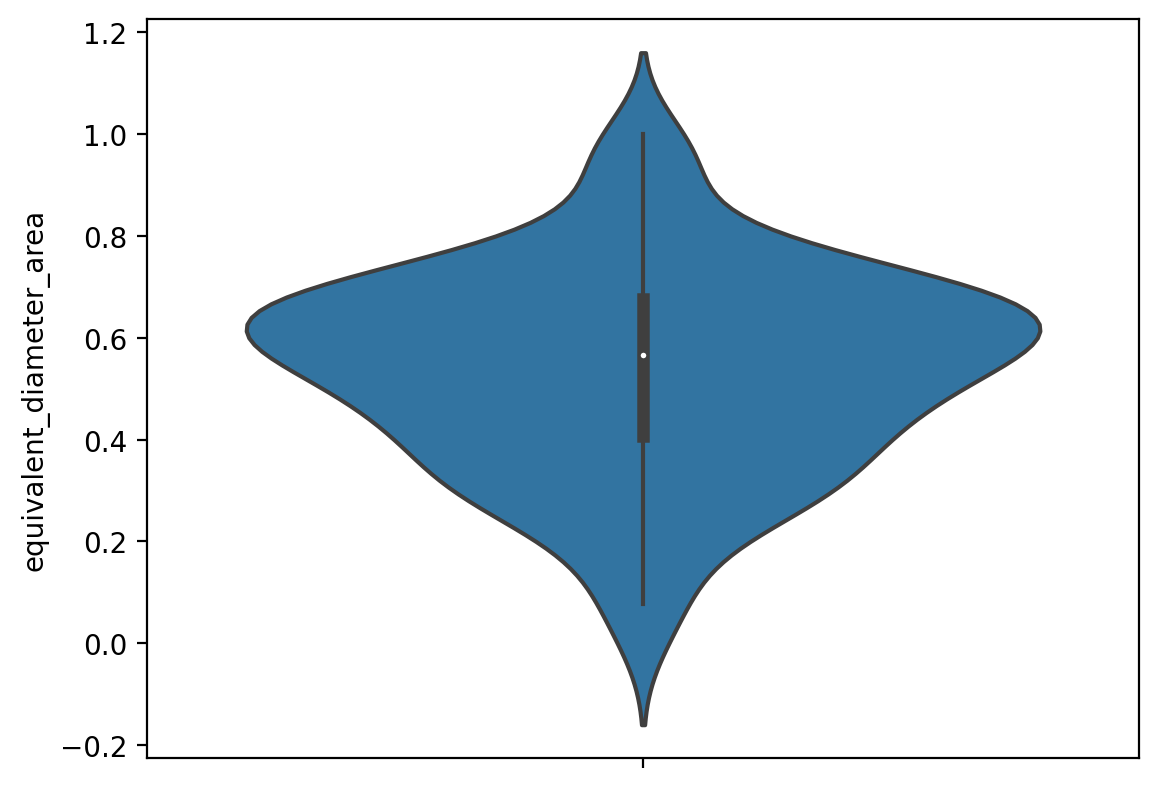

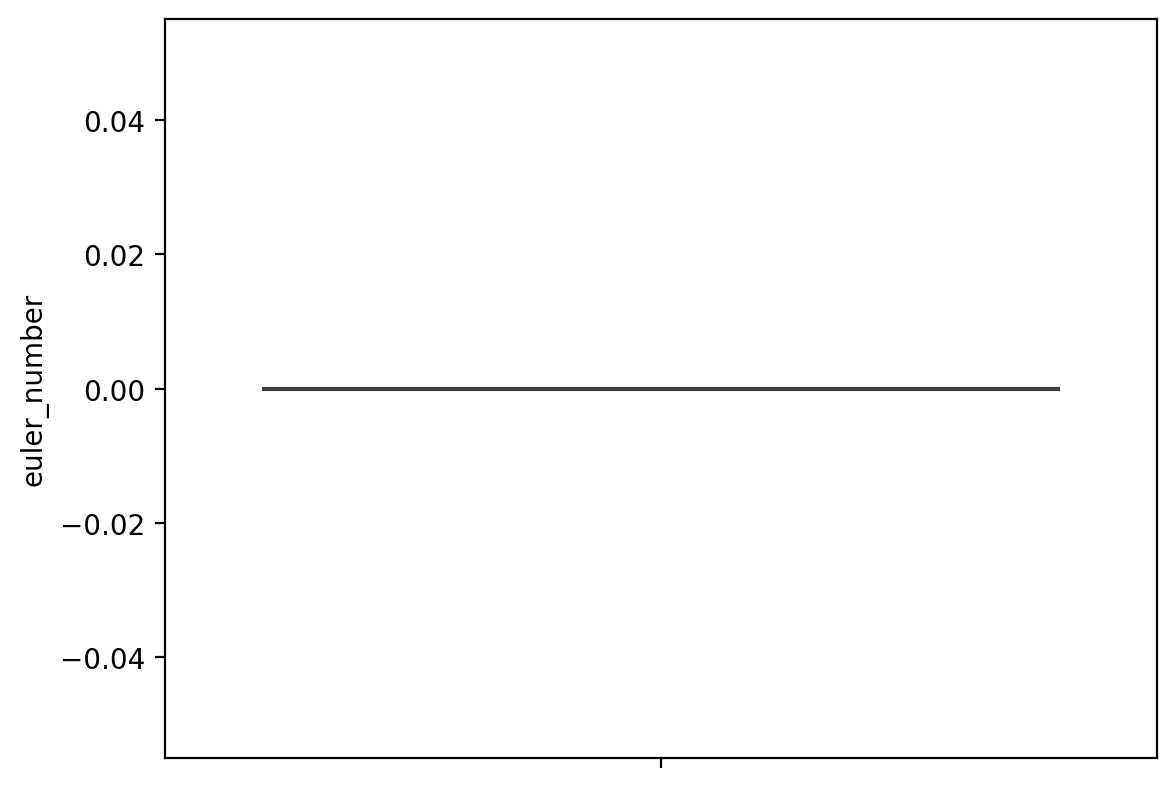

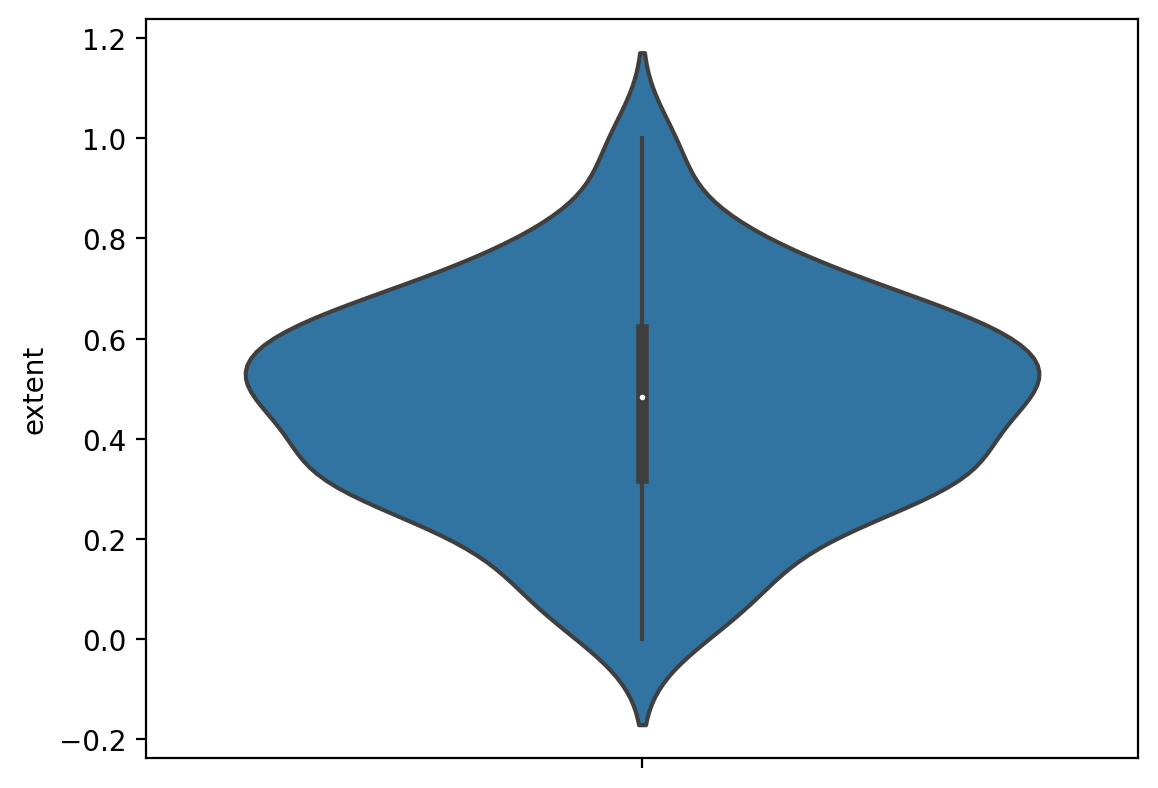

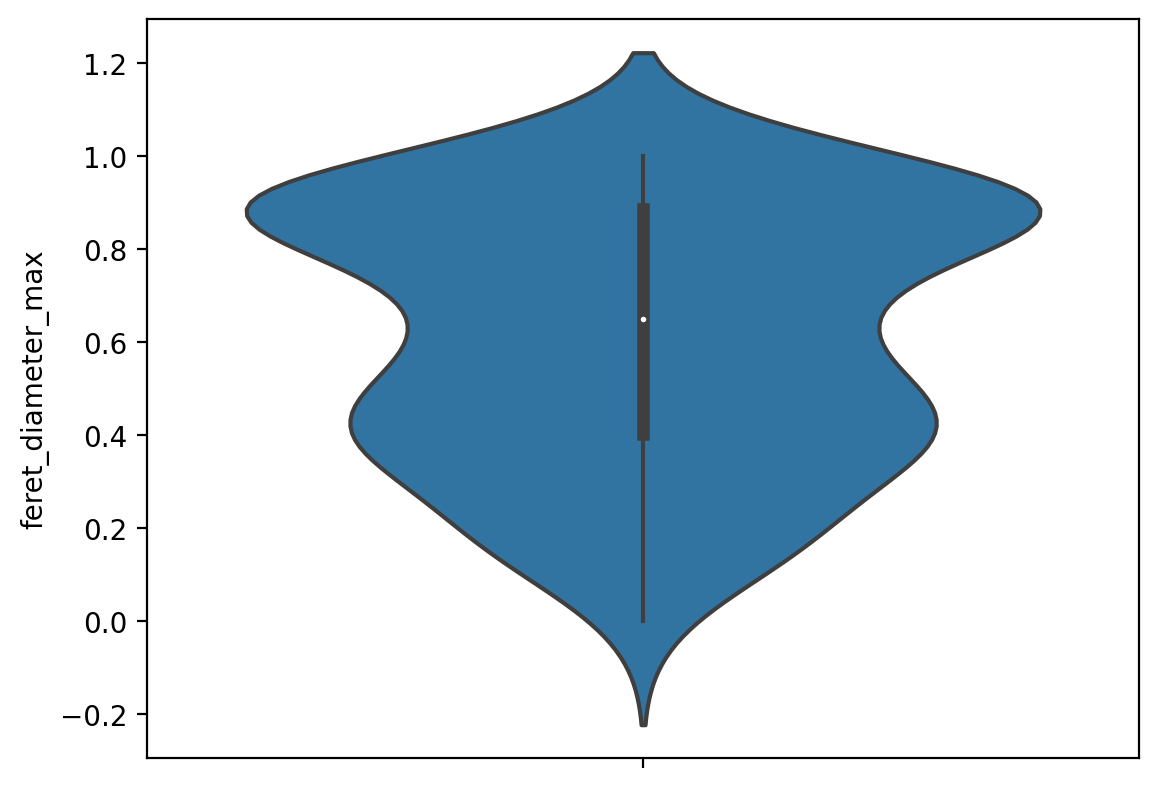

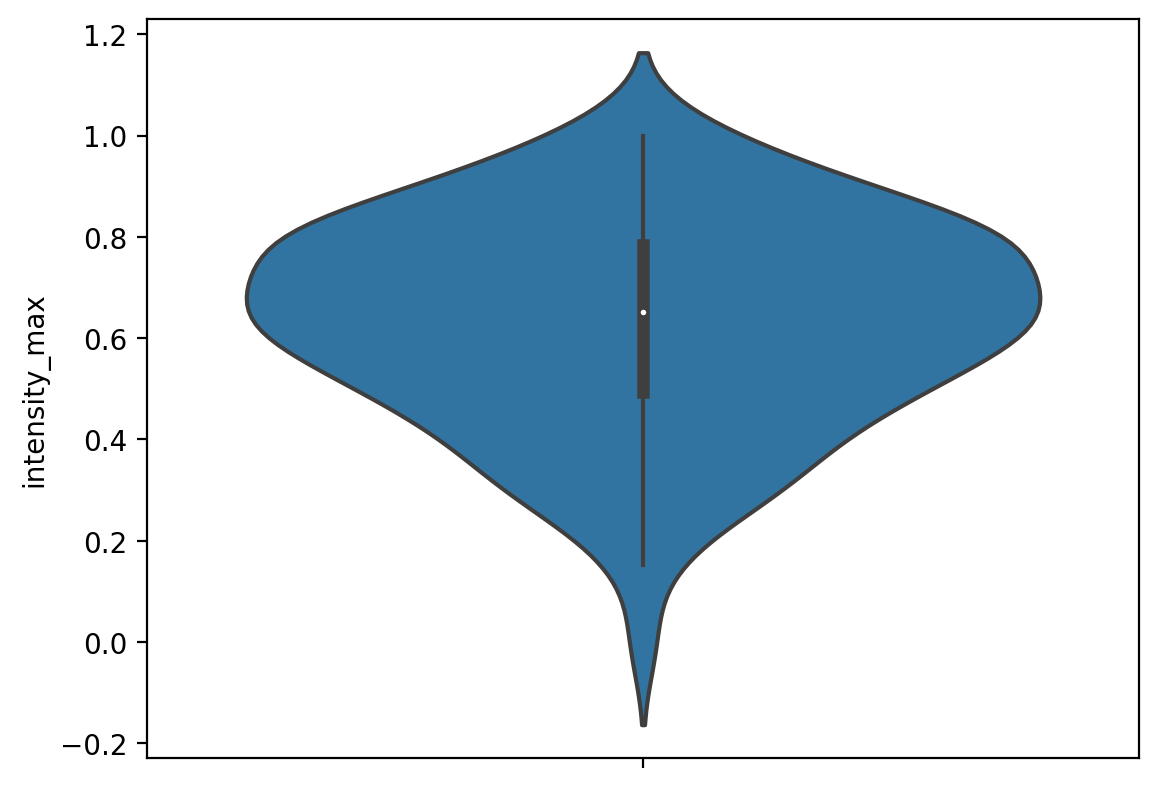

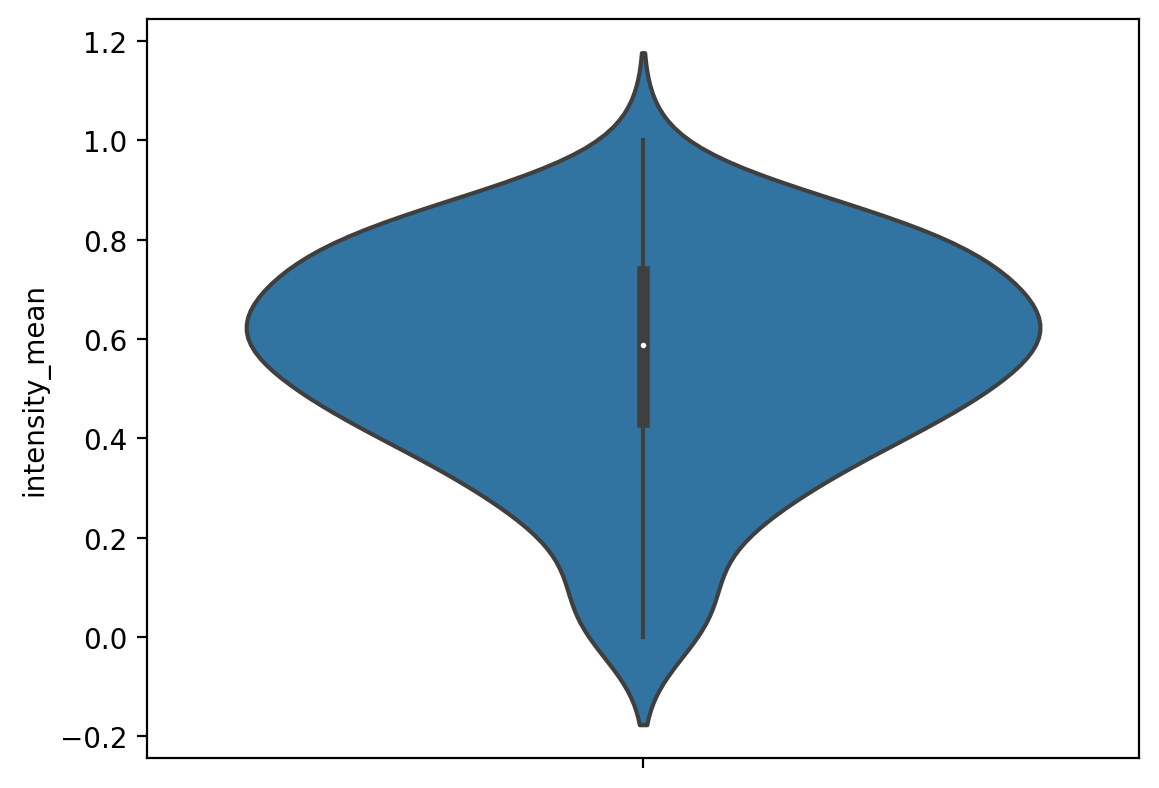

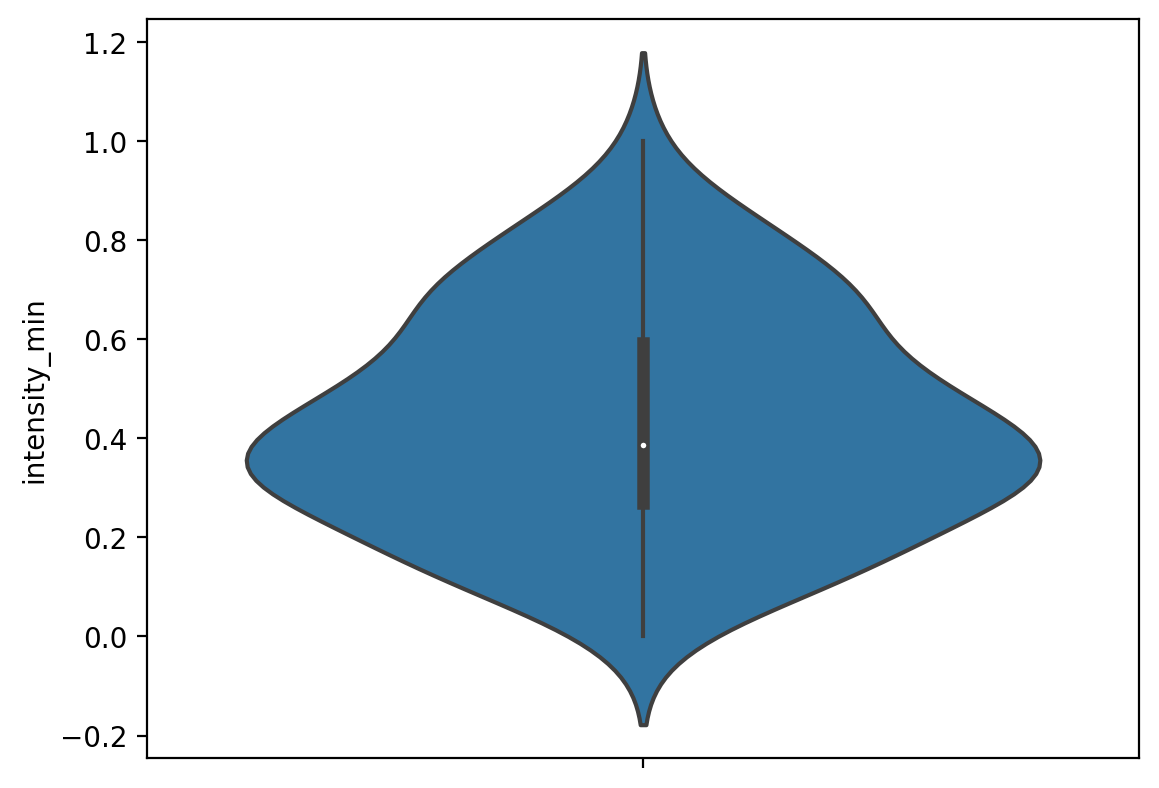

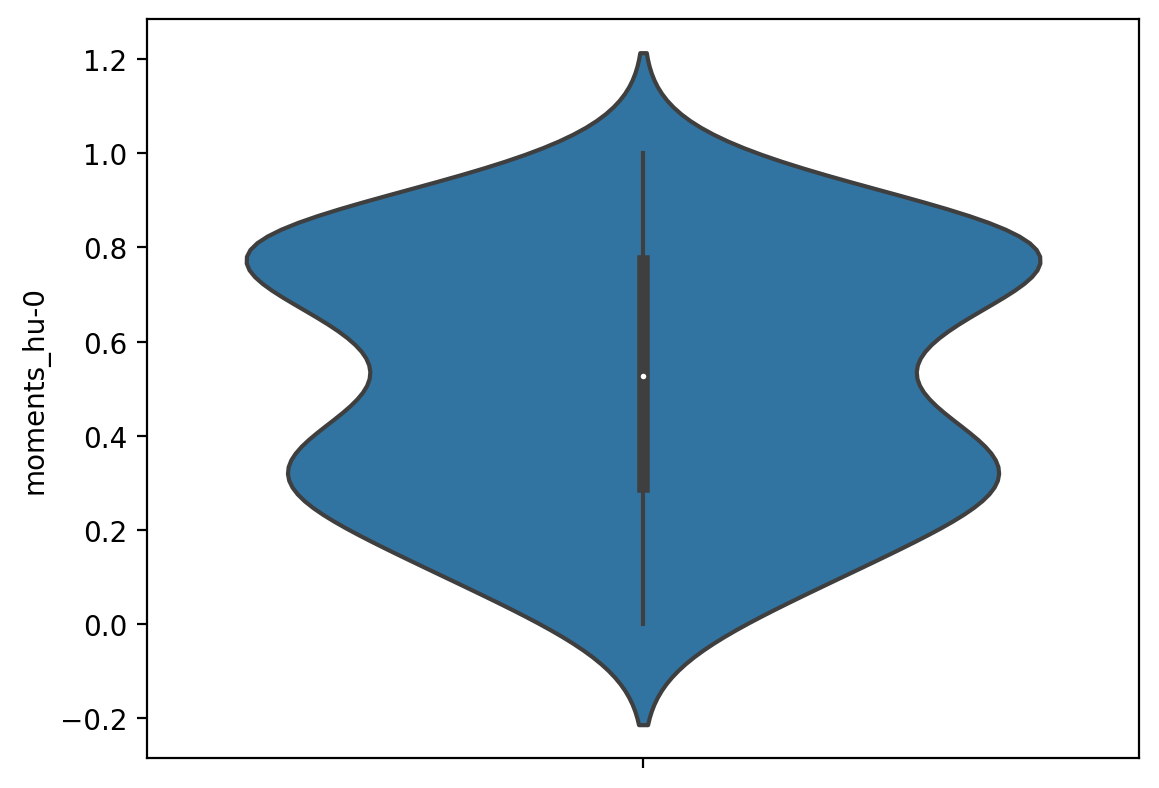

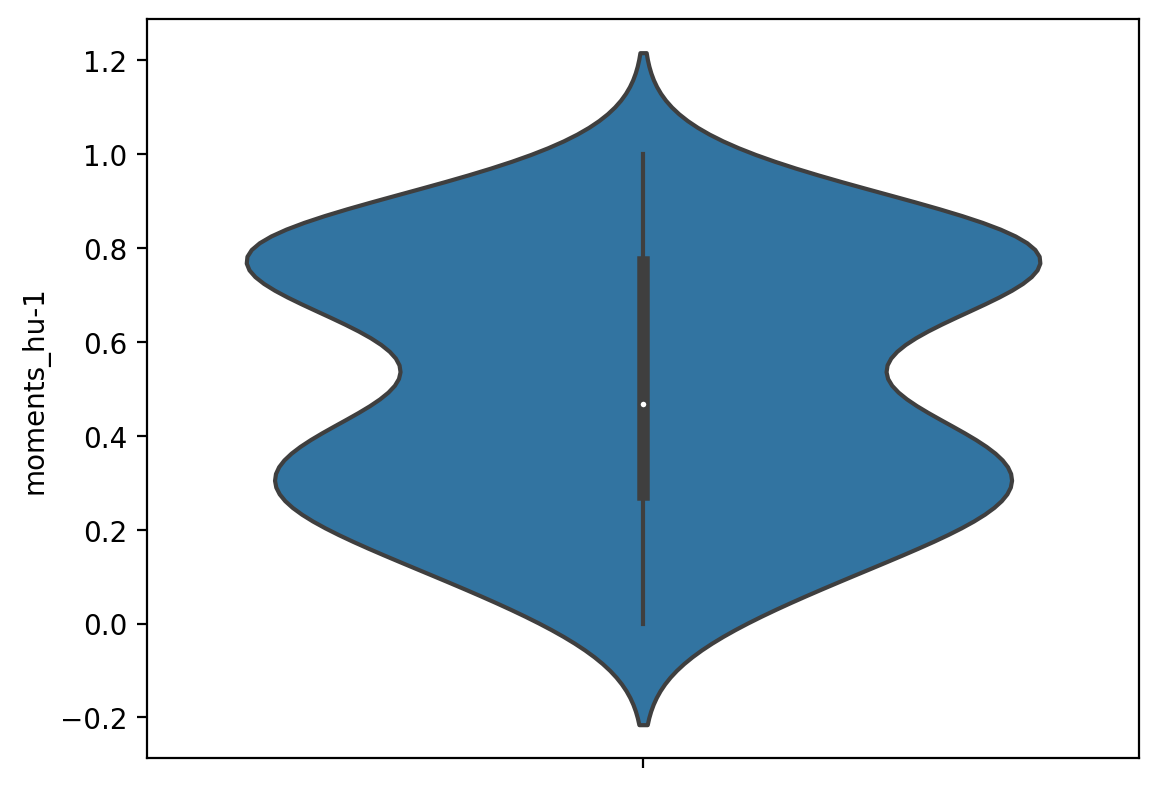

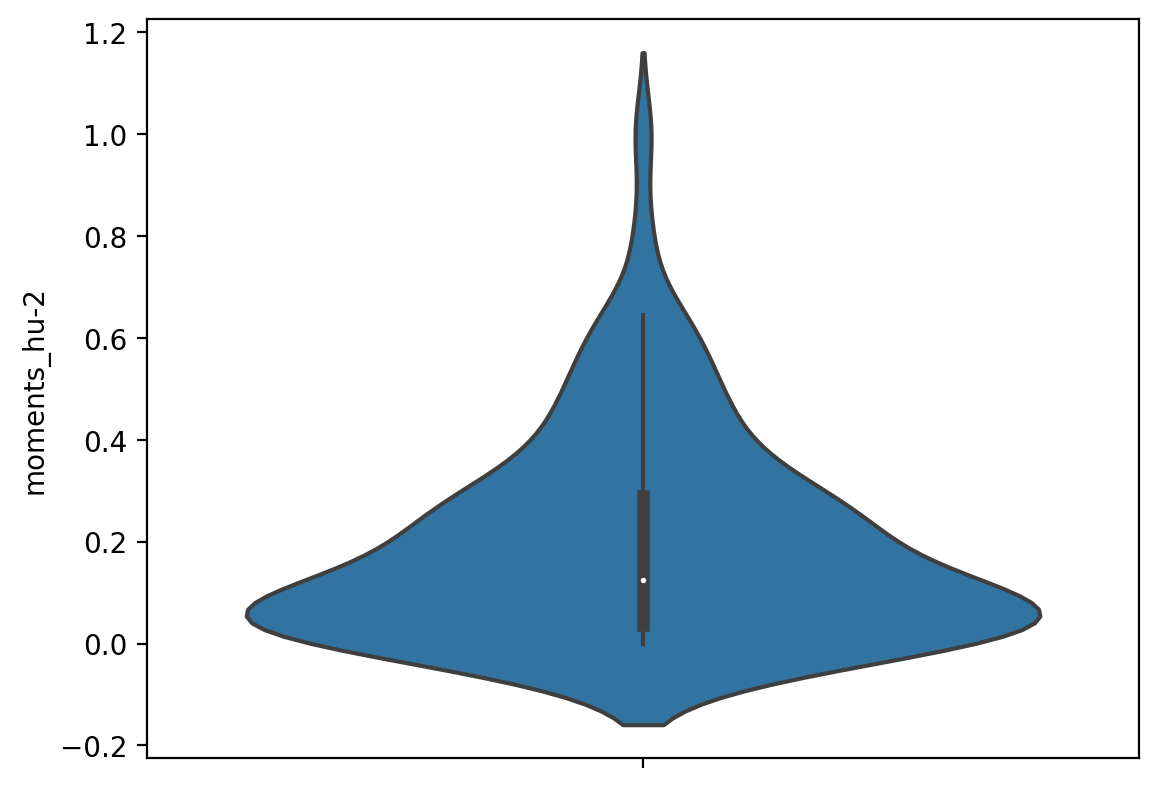

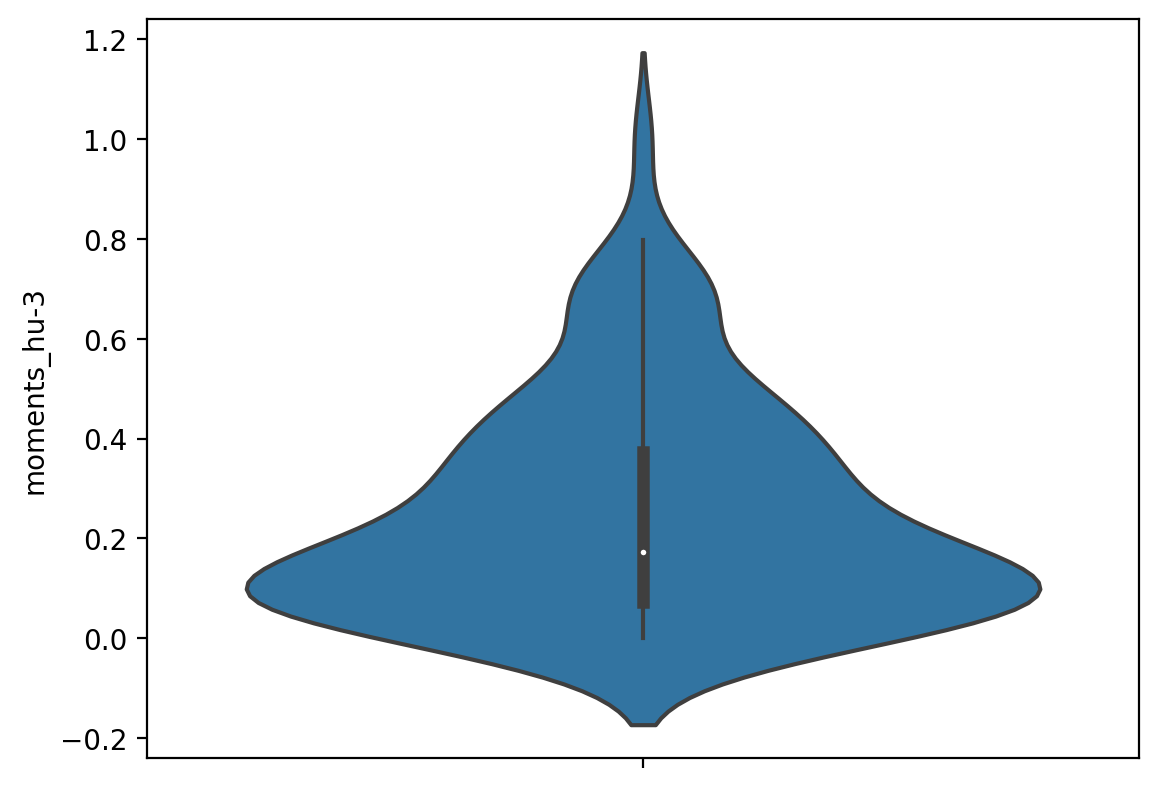

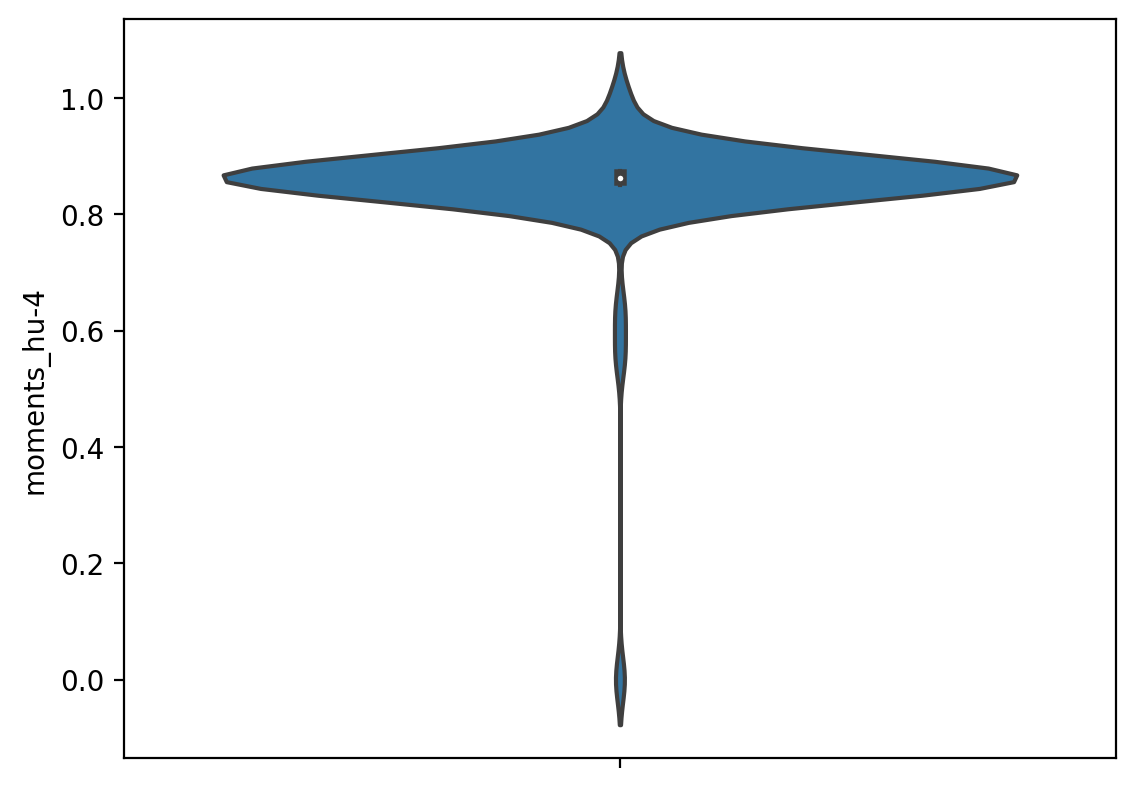

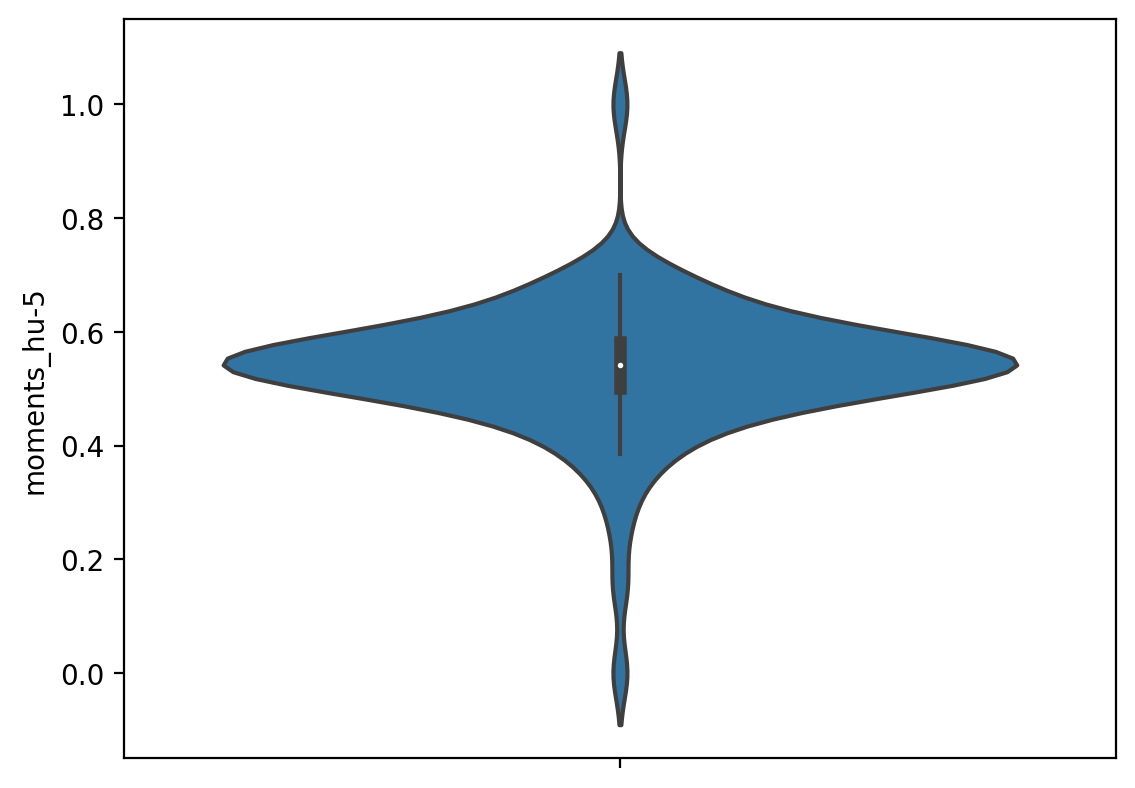

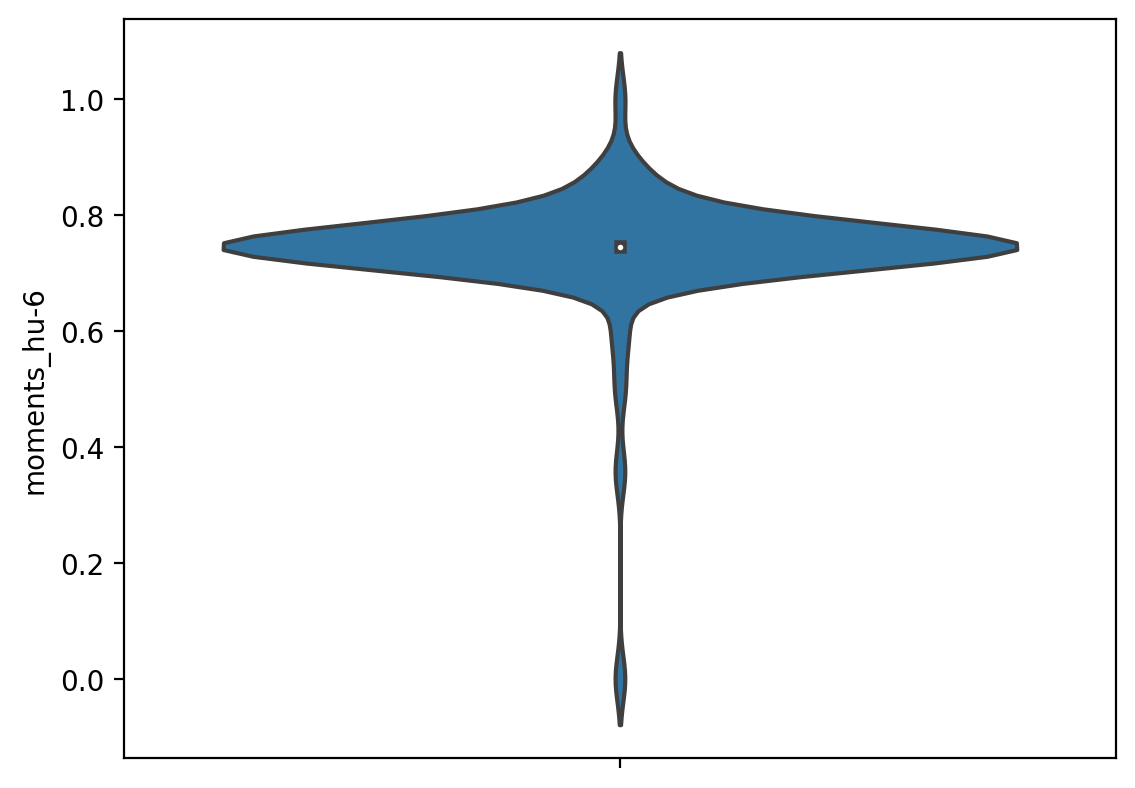

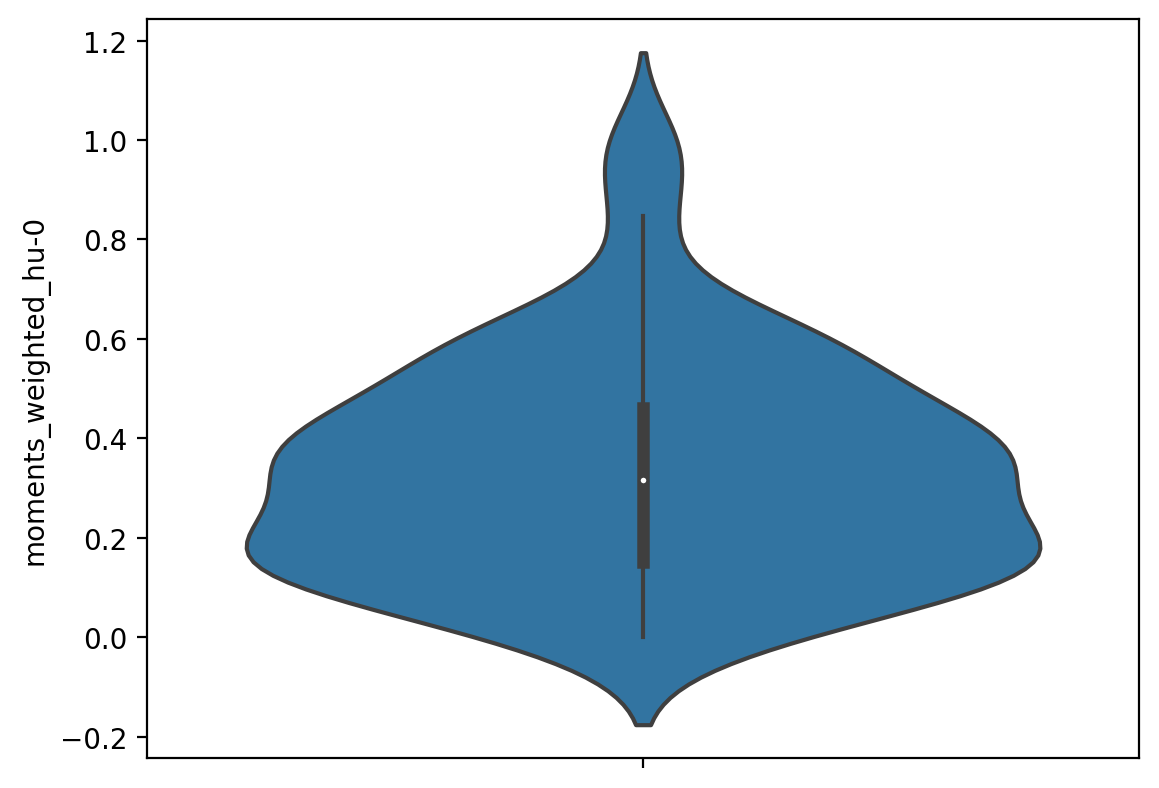

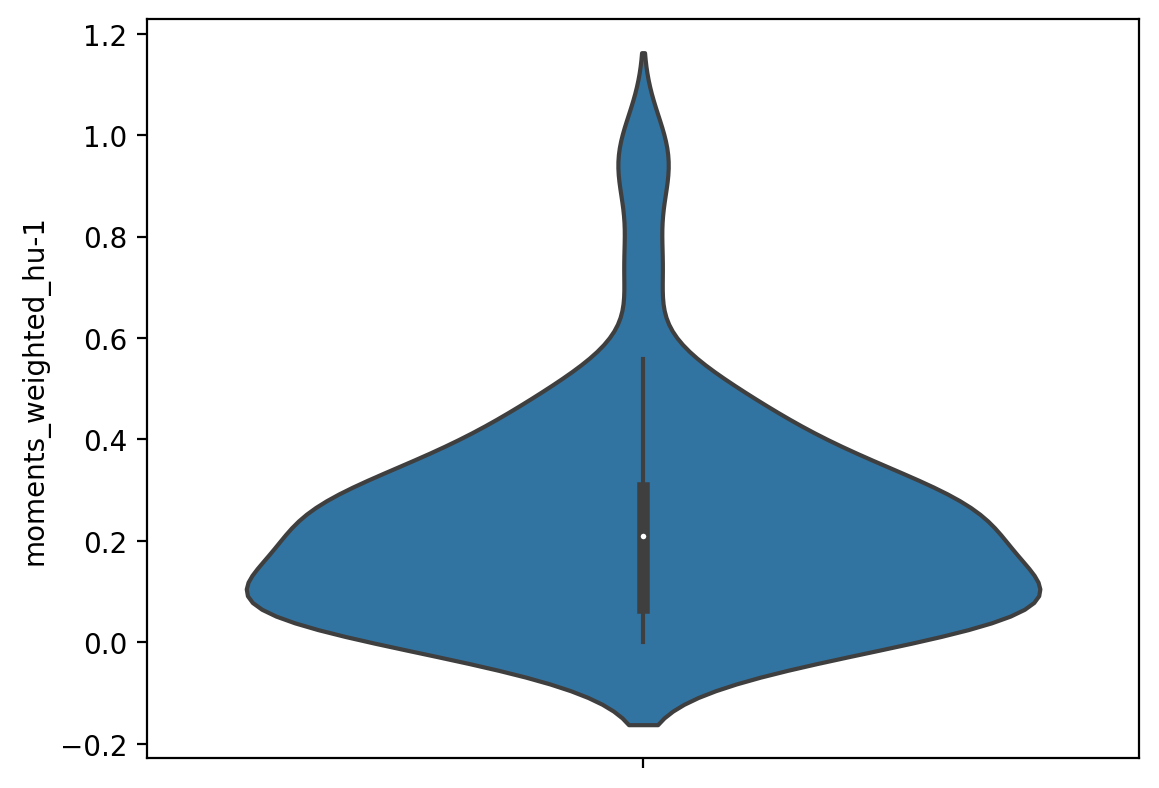

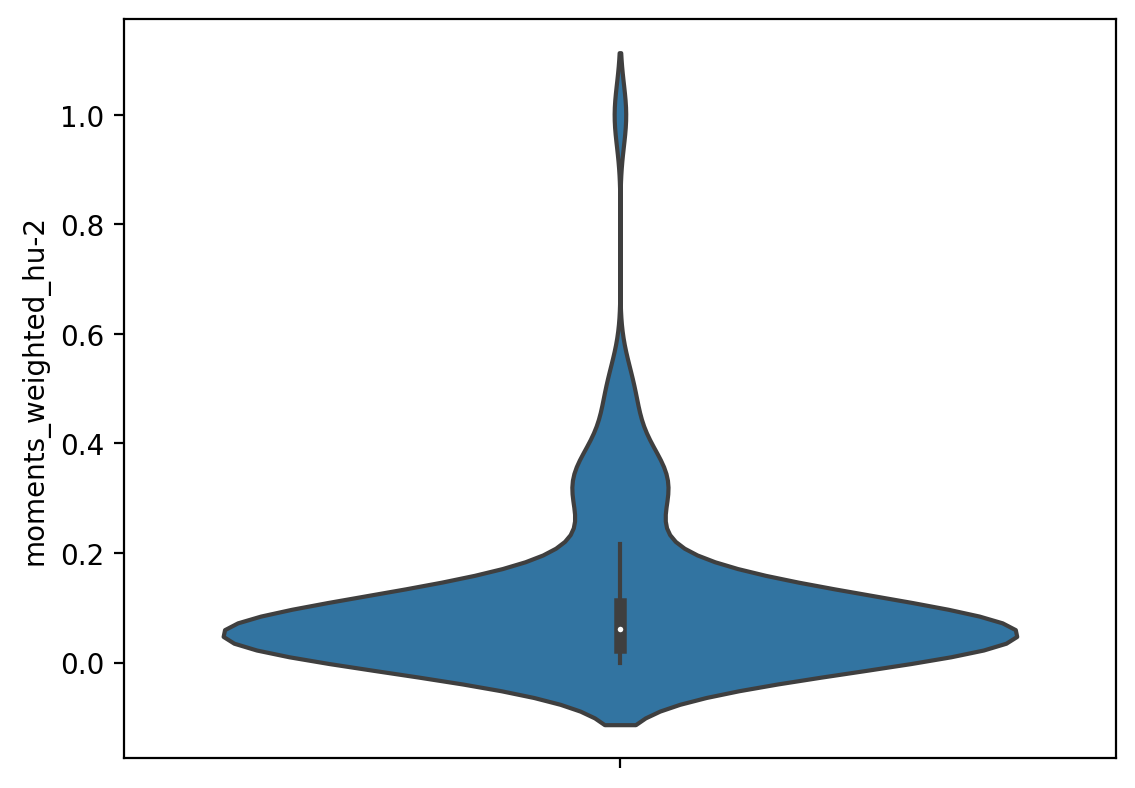

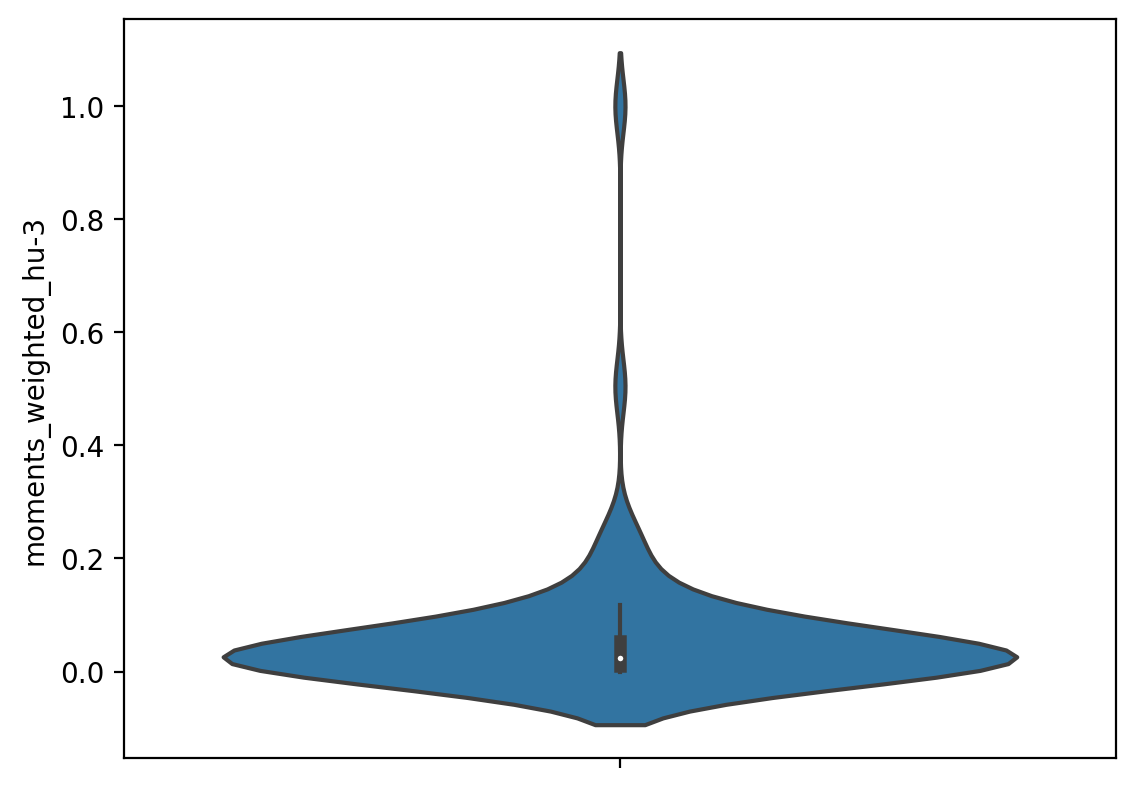

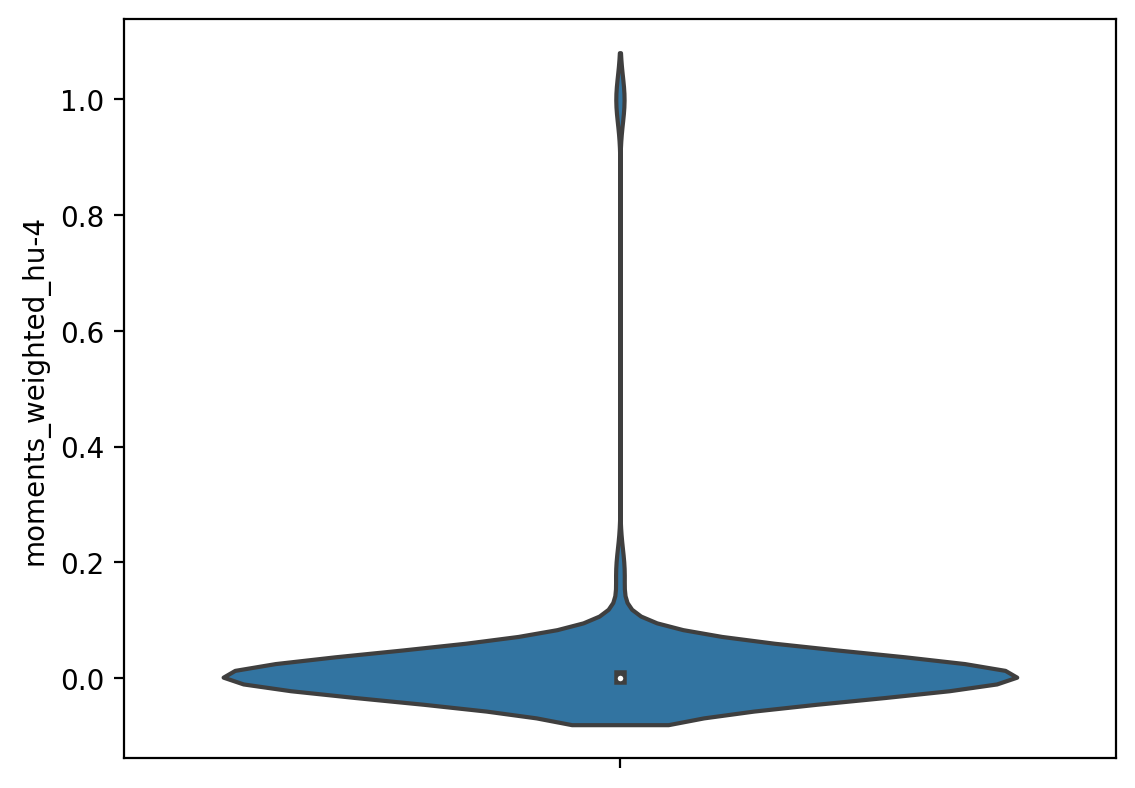

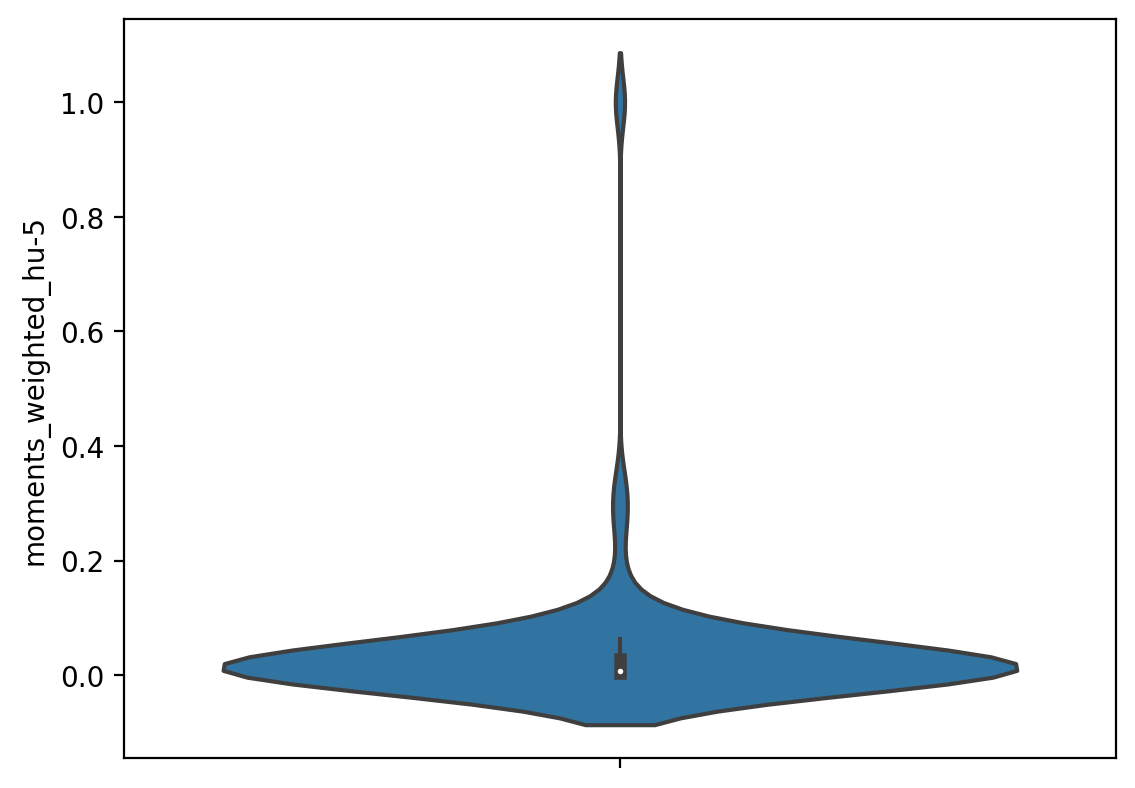

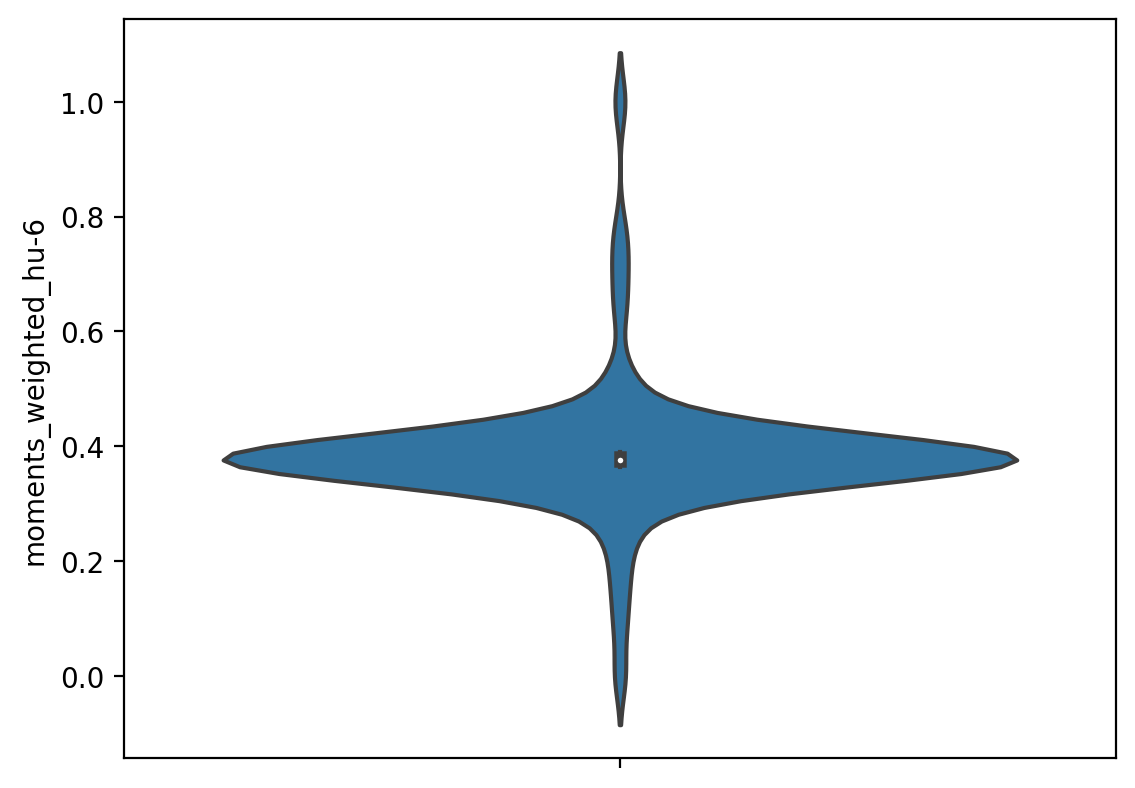

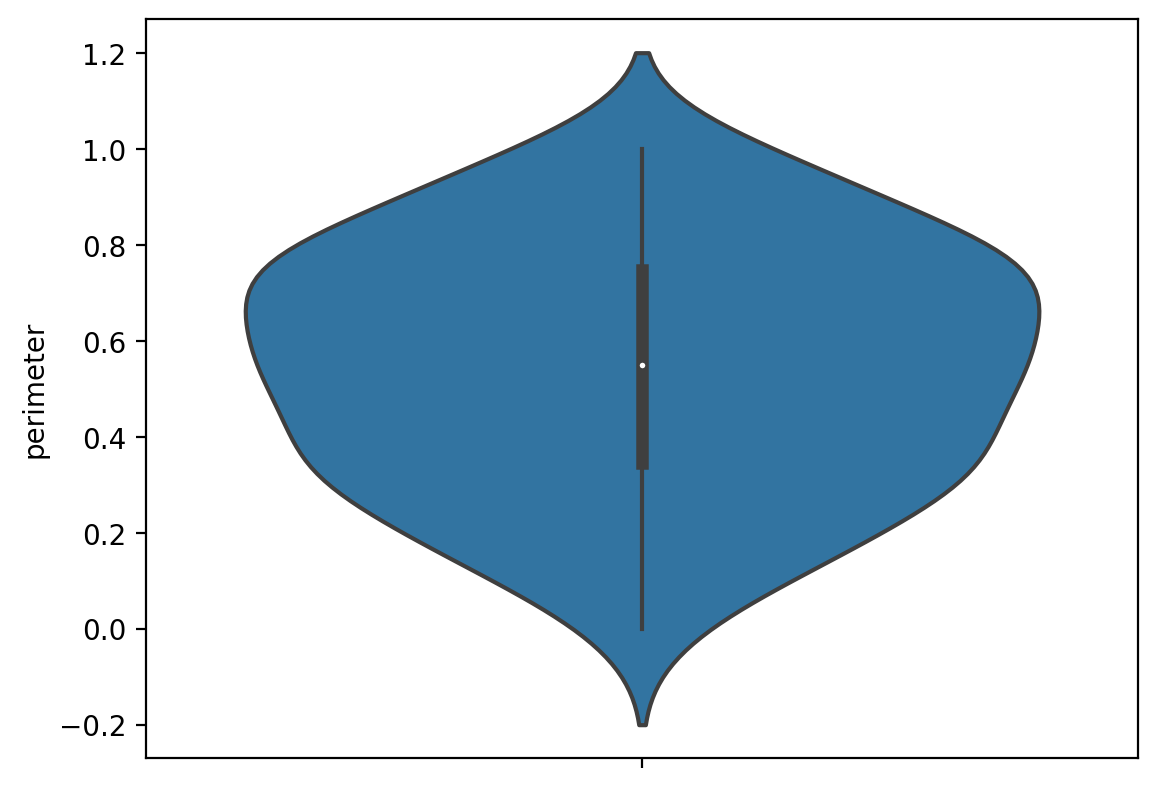

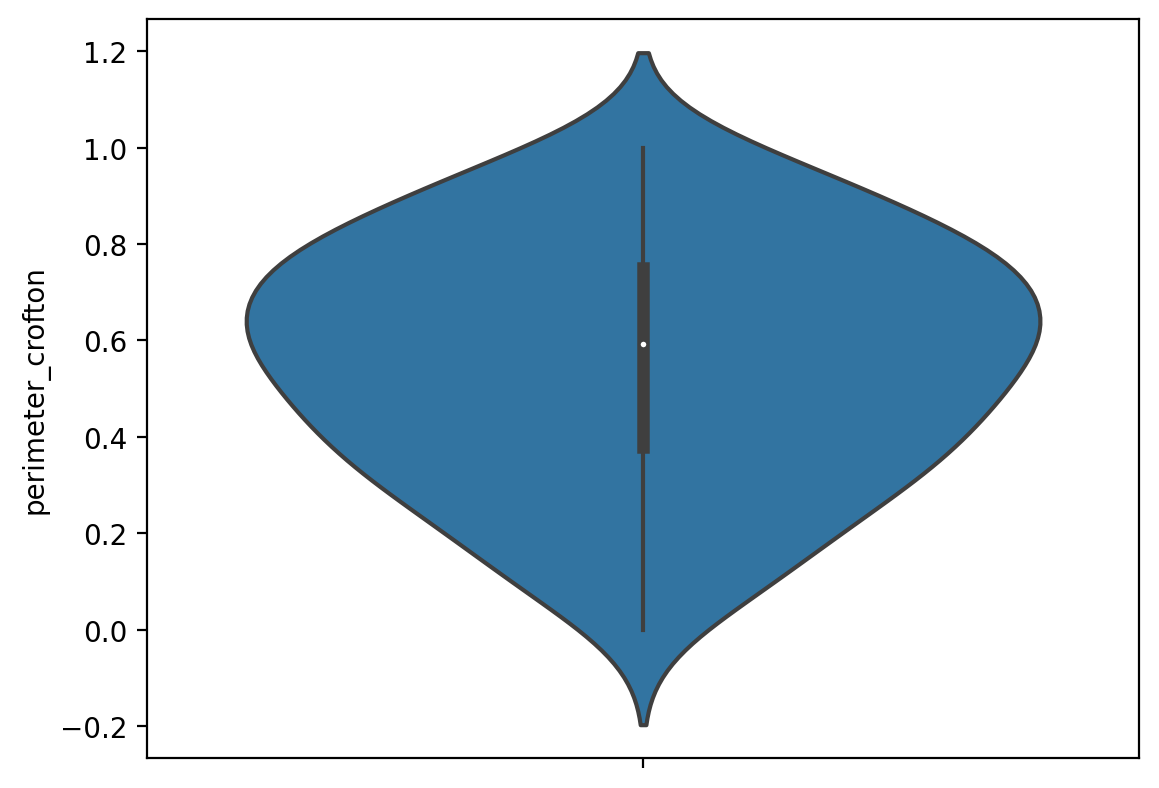

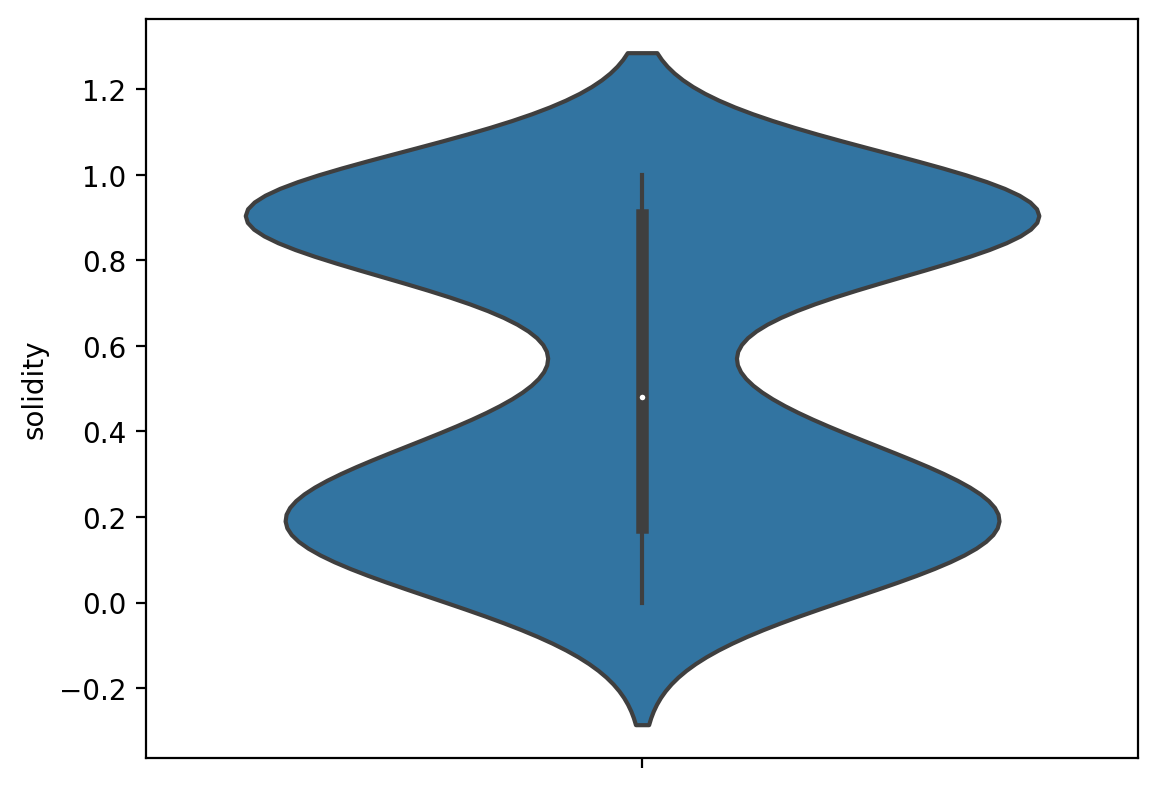

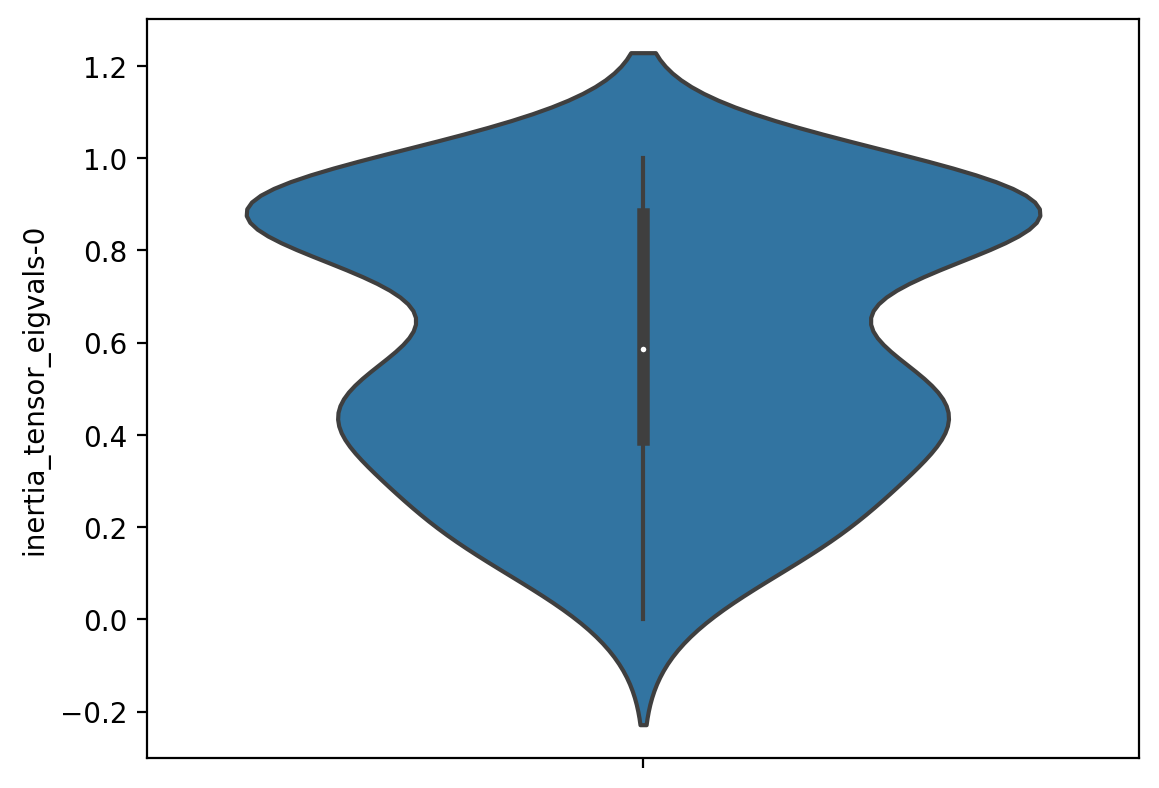

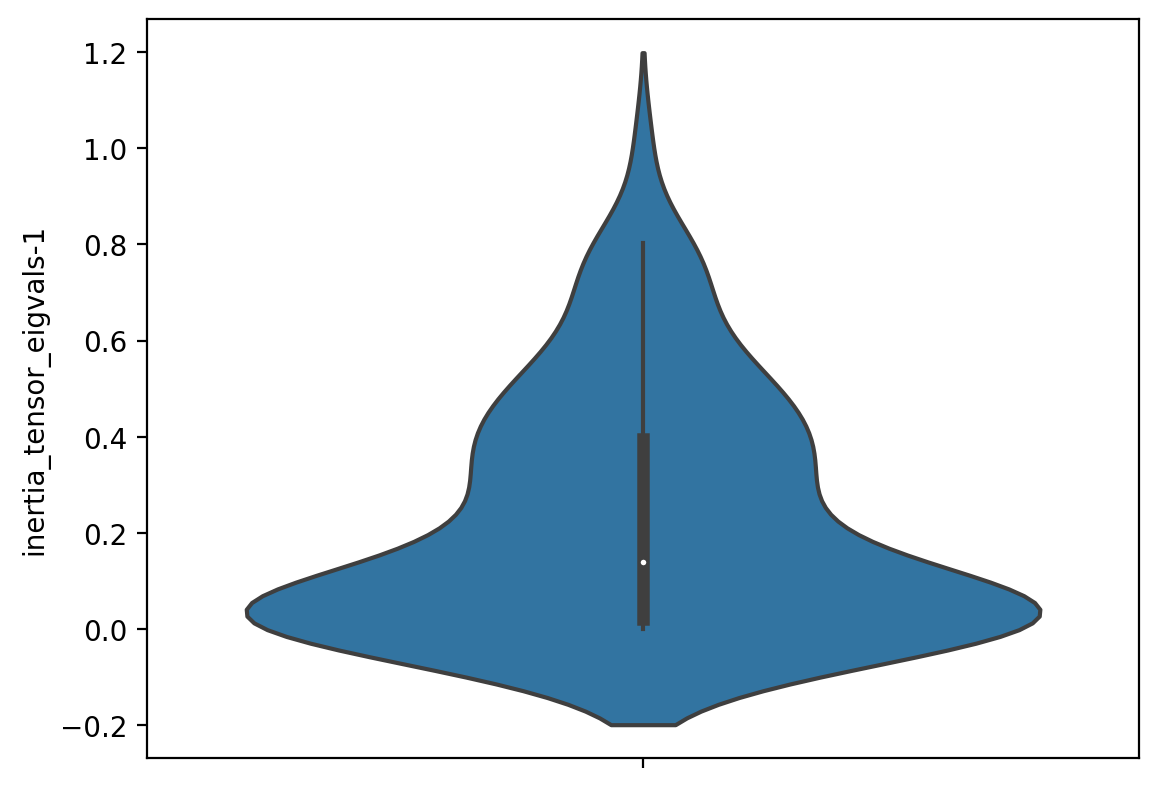

In [8]:
# Create a violin plot for each feature
for f in bbbc010_img_feats.keys():
    sb.violinplot(y = bbbc010_img_feats[f])

    plt.show()
    # The Euler number is constant and therefore useless. A bunch of other features (e.g., intensity_max, 
    # perimeter) are normally-distributed and therefore of limited use.

**2.2** Variance is a a good proxy for how informative a feature is. Intuitively, any feature that remains constant (or almost constant) throughout the dataset is unlikely to be helpful when it comes to classifying. A simple way to automate the identification of such low-variance features is to set a variance threshold and spot any feature that varies less than that. Run the lines below to load the VarianceThreshold method from scikit-learn and apply it to our feature matrix. Does the result corroboate your observations from 2.1?

In [9]:
from sklearn.feature_selection import VarianceThreshold

In [10]:
# Define what is considered as too low variance
epsilon = 1e-5
variance_thresh = VarianceThreshold(threshold = epsilon)

# Apply variance threshold
variance_thresh.fit(bbbc010_img_feats)

# Display low-variance features
print(list(bbbc010_img_feats.columns[~variance_thresh.get_support()]))
# We do retreive the Euler number, that we identified in 2.1 as being constant.

['euler_number']


**2.3** In addition to being informative on their own, we would also like features in our matrix to not be redundant. In other words, we do not want features to correlate too much with each other. This can be investigated by looking at the correlation matrix below. Do you identify groups of features that are heavily correlated? Do you intuitively understand why?

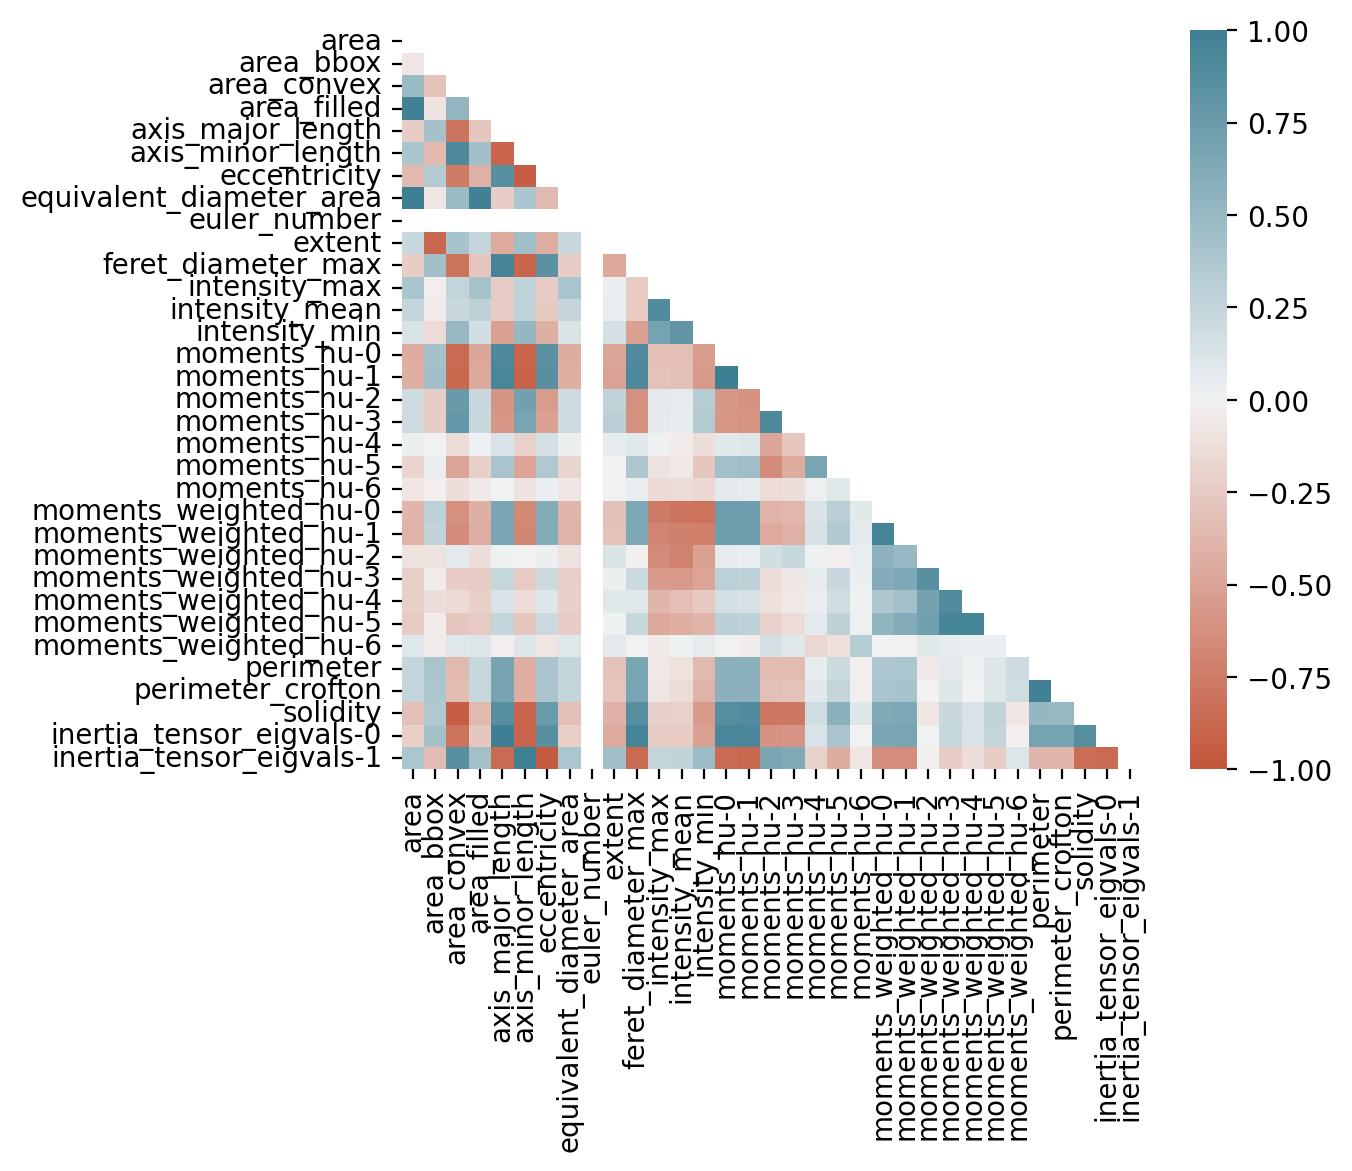

In [11]:
# Calculate the correlation matrix
correlation_matrix = bbbc010_img_feats.corr()

# Generate a mask for the upper triangle
upper_mask = np.triu(correlation_matrix.corr())

# Visualize the result as a heatmap
palette = sb.diverging_palette(20, 220, n = 256)

sb.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, vmin=-1, vmax=1, center=0, cmap=palette,
           square=True, mask=upper_mask)

plt.show()
# Groups of features that capture the same aspect are correlated. Examples include solidity with area_convex, 
# area_filled with area, extent with area_bbox, feret_diameter_max with axis_minor_length and axis_major_length.

**2.4** When ground-truth class labels are available, Mutual Information provides a formal way of evaluating whether features are predictive of the class label or not. It ranges between 0 when the feature is independent from the class label, to positive values when the feature is dependent on the class, with higher values indicating a stronger dependency. Mutual Information is based on the notion of Shannon entropy, a core theoretical concept in information theory (https://en.wikipedia.org/wiki/Mutual_information). 

Run the lines below to compute the Mutual Information of the features in our matrix and visualize the result. Which ones do you identify as being informative? Does the result corroboate your observations from 2.2?

In [12]:
from sklearn.feature_selection import mutual_info_classif

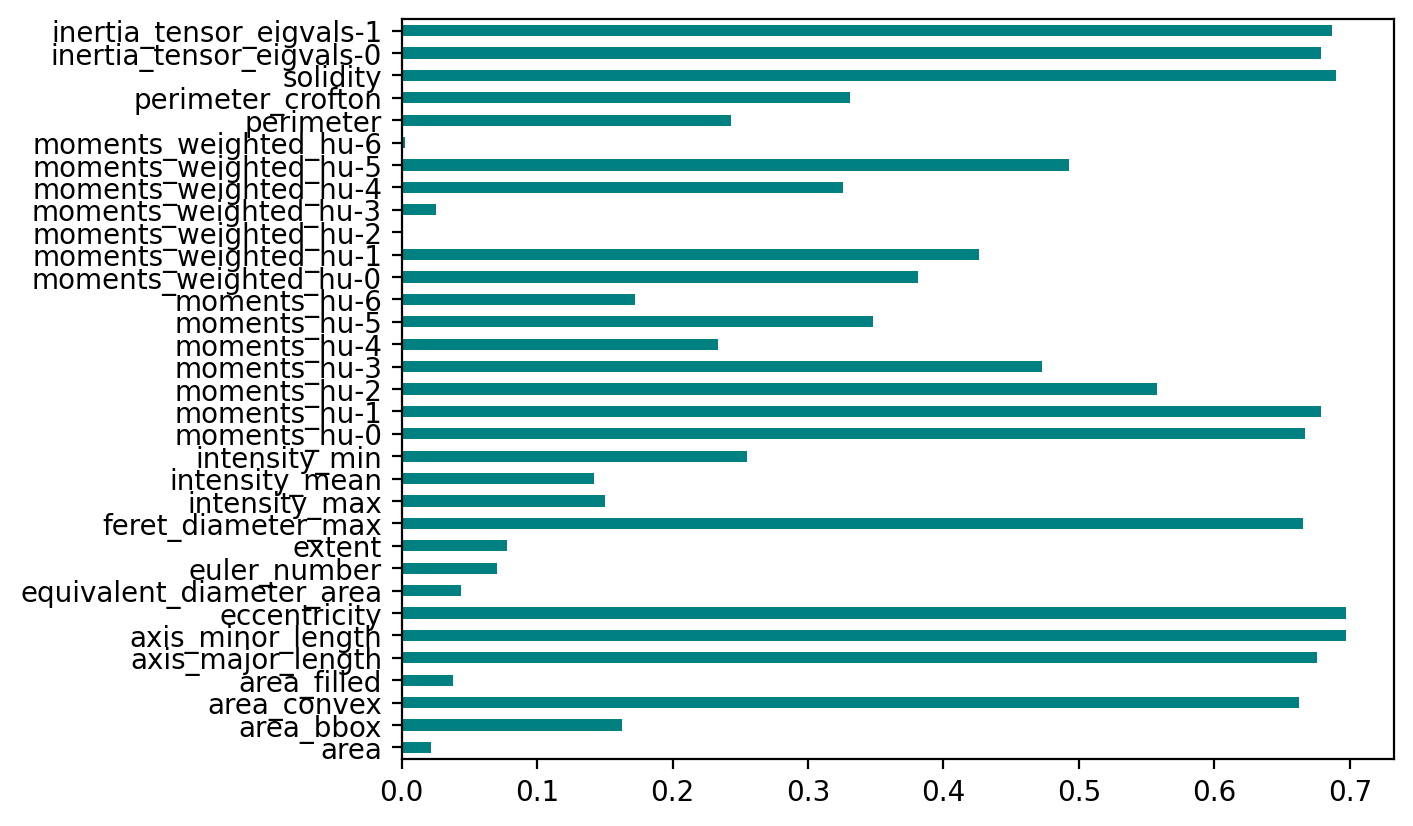

In [13]:
# Create matrix of data and labels
X = bbbc010_img.loc[:, bbbc010_img.columns != 'label']
Y = bbbc010_img.loc[:, 'label']

# Compute feature importance
importance = mutual_info_classif(X,Y)

# Visualize the result
feature_importance = pd.Series(importance, bbbc010_img.columns[0: len(bbbc010_img.columns)-1])
feature_importance.plot(kind='barh', color='teal')

plt.show()
# The Euler number, that we already identified as constant, is identified here as well to be uninformative. 
# Other features such as moments_weighted_hu-2 and moments_weighted_hu-6 are flagged as uninformative. 
# Interestingly, they appear to be uncorrelated with most other measurements in 2.3, but also seem to have
# highly multimodal distributions, as seen in 2.1.

**2.5** Beyond selecting individual features, another way to reduce the dimensionality of our feature matrix is to try and find a few combinations of features that can explain most of the variability present in the matrix. This is the idea behind the famous principal component analysis (PCA, https://en.wikipedia.org/wiki/Principal_component_analysis). 

Run the lines below to 1) extract the first N principal components of our feature matrix, and 2) plot the  variance that they are able to explain. Based on this, how many principal components do you think is sufficient to analyze this dataset? How does that compare to the number of features we initially had, and how does that relate to your observations in 2.1 and 2.3?

In [14]:
from sklearn.decomposition import PCA

Percentage of variance explained with 10 principal components: 96.13


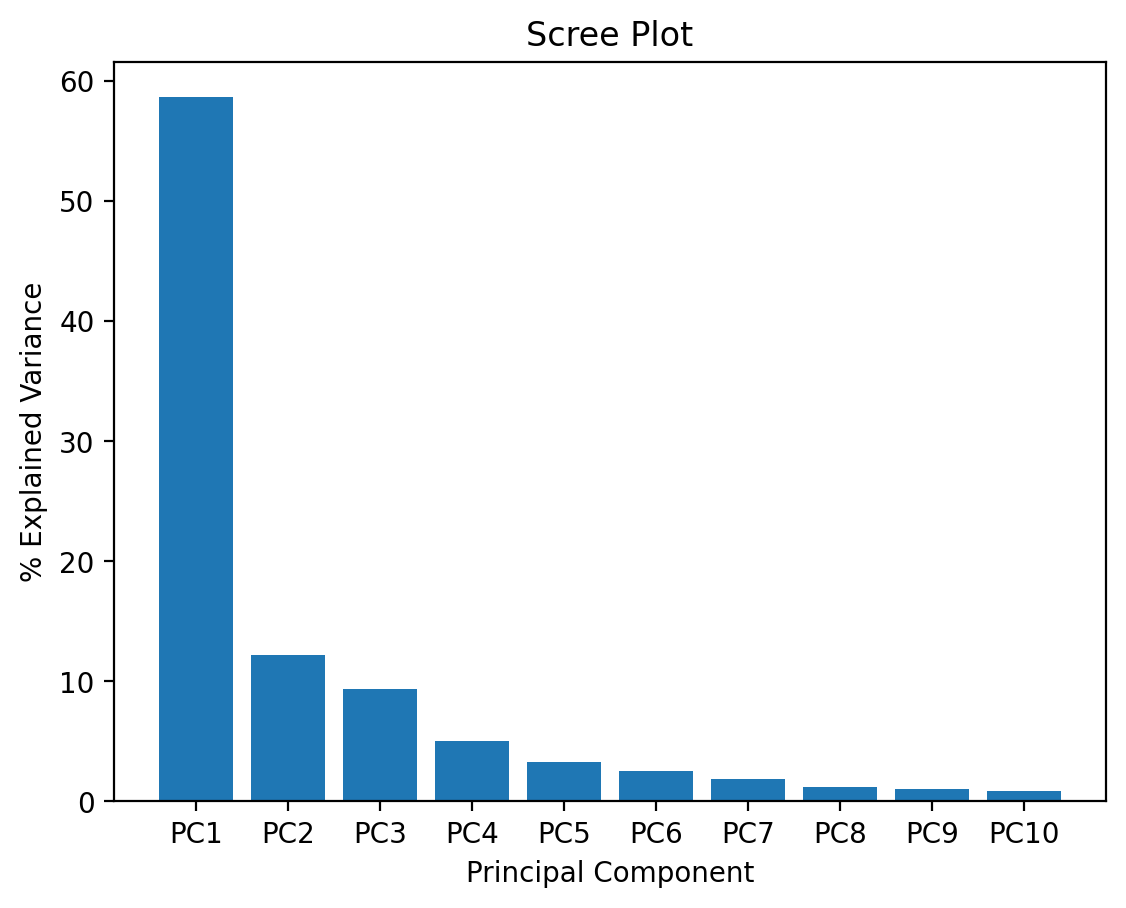

In [15]:
# Fix the number of principal components to be extracted
N = 10

# Perform PCA
pca = PCA(n_components = N)
pca.fit(bbbc010_img_feats)

# Retreive the % of variance explained by each Principal Component
percent_variance_explained = np.round(pca.explained_variance_ratio_* 100, decimals=2)
print("Percentage of variance explained with "+str(N)+" principal components: "+str(np.sum(percent_variance_explained)))

# Visualize the explained variance (scree plot)
pc_labels = ['PC'+str(x) for x in range(1, len(percent_variance_explained)+1)]
plt.bar(x = range(1,len(percent_variance_explained)+1), height = percent_variance_explained, 
        tick_label = pc_labels)

plt.ylabel('% Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')

plt.show()
# 99% of the variance is explained with 17 principal components, so we certainly don't need more than 17 features
# to fully characterize this dataset. It means that almost half of the features in our matrix (composed of 33 in 
# total) can be dropped. This is consistent with our observations that several features are normally distributed
# (2.1) and that many of them exhibit strong correlations with each other (2.3).

**2.6** PCA, in 2.5, finds a lower-dimensional subspace that maximizes the variation in the whole data set, without accounting for classes. Here, since we also have ground truth labels, we can alternatively apply Linear Discriminant Analysis (LDA, https://en.wikipedia.org/wiki/Linear_discriminant_analysis). LDA aims at retreiving a feature subspace that maximizes the variance between our two classes (*inter-class* variance) while minimizing the variance within each given class (*intra-class* variance). 

Run the lines below to 1) perform LDA on the feature matrix, and 2) plot the data according to the linear discriminant value. Below, we also provides code to plot the data according to the value of their first principal component. Which one of LDA or PCA do you think is better in this case? Can you guess why?

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

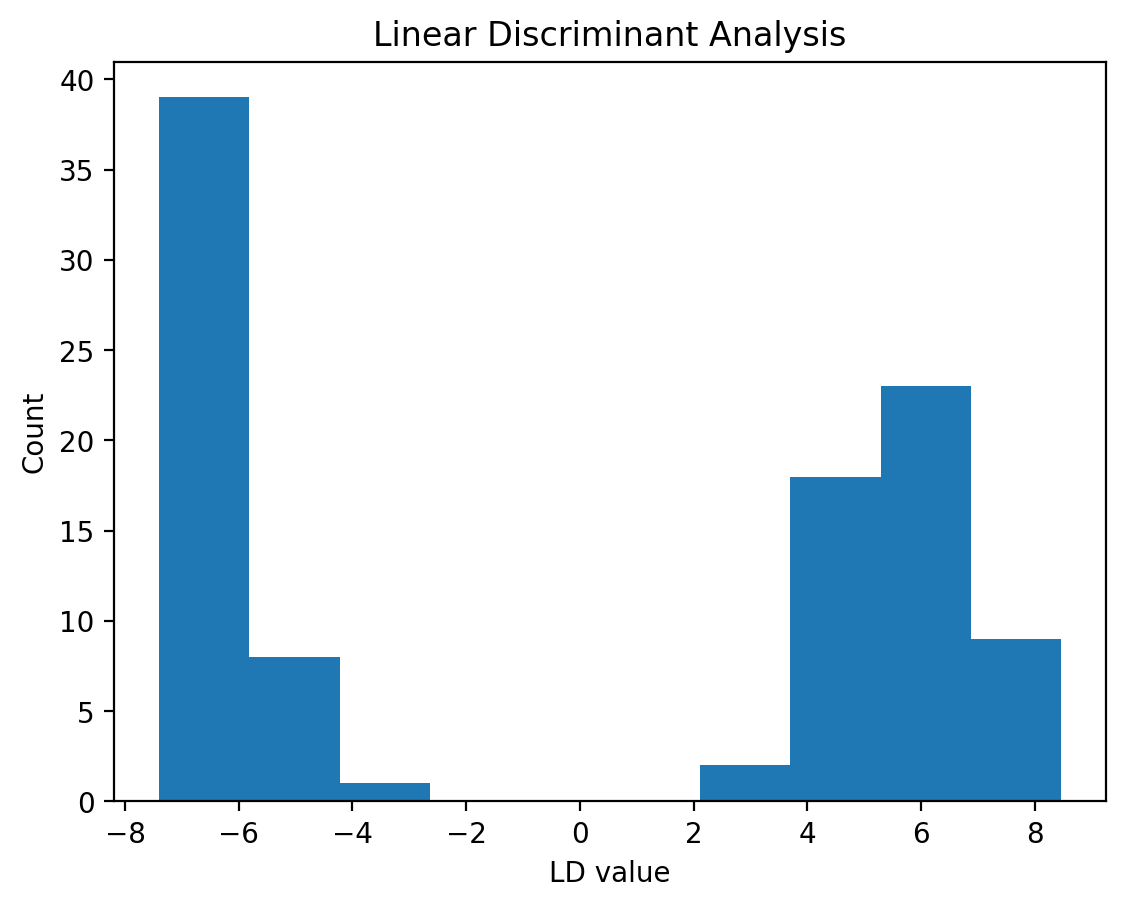

In [17]:
# Create matrix of data and labels
X = bbbc010_img.loc[:, bbbc010_img.columns != 'label']
Y = bbbc010_img.loc[:, 'label']

# Perform LDA
lda = LinearDiscriminantAnalysis()
bbbc010_img_lda = lda.fit_transform(X, Y)

# Visualize the result
plt.hist(bbbc010_img_lda)

plt.xlabel('LD value')
plt.ylabel('Count')
plt.title('Linear Discriminant Analysis')

plt.show()

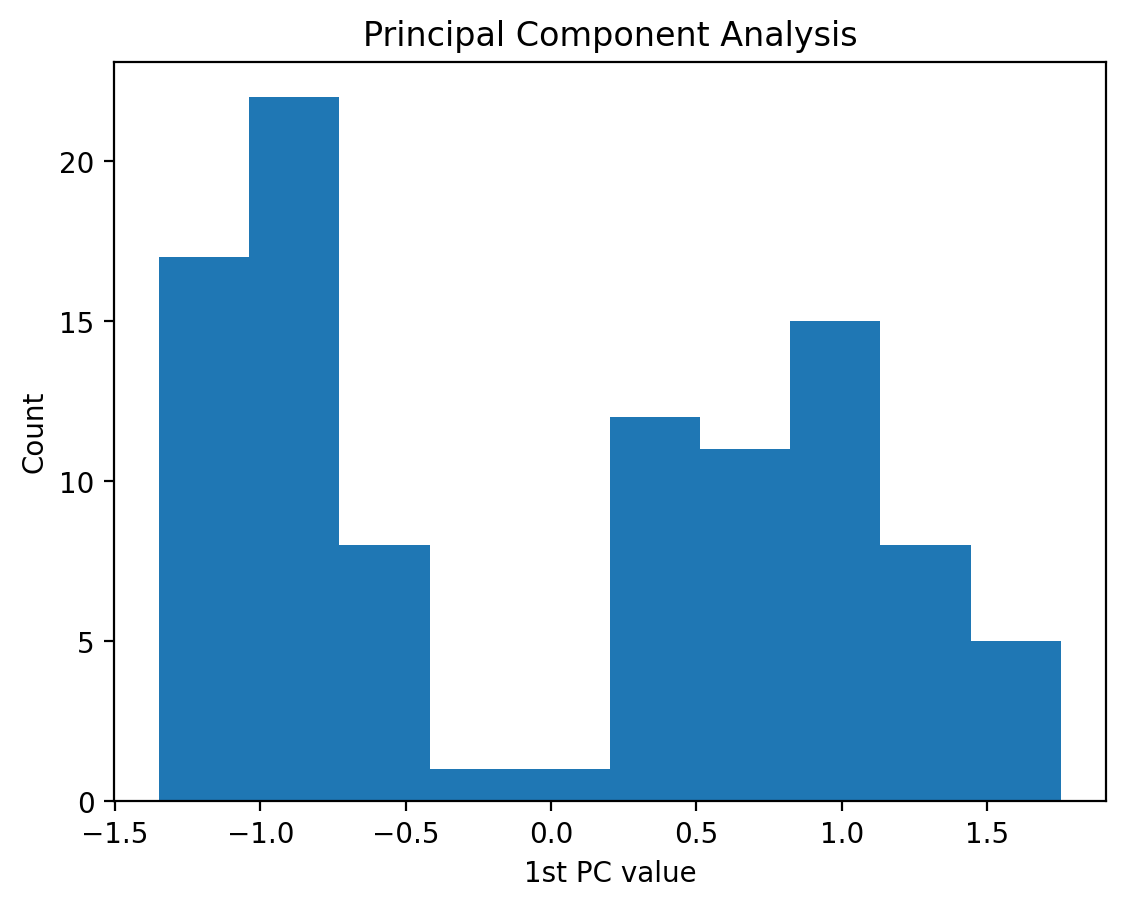

In [18]:
# Perform PCA
pca = PCA(n_components = 1)
pca.fit(bbbc010_img_feats)

# Transform the data into their PC
bbbc010_img_pca = pca.transform(bbbc010_img_feats) 

# Visualize the result
plt.hist(bbbc010_img_pca)

plt.xlabel('1st PC value')
plt.ylabel('Count')
plt.title('Principal Component Analysis')

plt.show()
# It looks like LDA is maginally better than PCA, as it allows identifying two well-separated groups.

## 3. Unsupervised classification

Now that we have identified strategies to "clean" our feature matrix, we can dig into the actual classification and try to automatically retreive which group each sample belongs to. We will first look at *unsupervised* classification methods that do not require knowledge of the underlying class labels.

**3.1** K-means clustering (https://en.wikipedia.org/wiki/K-means_clustering) is perhaps the most well-know unsupervised classification algorithm. In a nuthsell, K-means works as follows: 1) K data points are randomly selected as class centroids, 2) all other data points are associated to the centroid they are the closest to, 3) the class centroids are recomputed as the average of the points assigned to them. This procedure is iteratively repeated until convergence, revealing the "true" classes present in the dataset.

Run the lines below to retreive the class label obtained by running 2-means clustering on the LDA-transformed data. Then, adapt the code to run 2-means clustering on the PCA-transformed data, using the 1st principal component only (see 2.6). Do you see a difference?

In [19]:
from sklearn.cluster import KMeans

In [20]:
# There are two classes in this dataset
K = 2

# Perform K-means on LDA-transformed data
kmeans = KMeans(n_clusters=K, random_state=5)
kmeans.fit(bbbc010_img_lda)

# Retreive the cluster label and display it
kmeans_labels = kmeans.predict(bbbc010_img_lda)

kmeans_labels_lda = np.empty((len(kmeans_labels)), dtype='object')
kmeans_labels_lda[kmeans_labels == 0] = 'dead'
kmeans_labels_lda[kmeans_labels == 1] = 'live'

print(kmeans_labels_lda)

['dead' 'live' 'dead' 'dead' 'dead' 'live' 'live' 'live' 'dead' 'dead'
 'dead' 'dead' 'live' 'live' 'live' 'dead' 'dead' 'live' 'dead' 'live'
 'live' 'dead' 'dead' 'dead' 'dead' 'live' 'live' 'live' 'live' 'live'
 'dead' 'live' 'dead' 'dead' 'dead' 'live' 'live' 'live' 'live' 'live'
 'dead' 'live' 'live' 'live' 'live' 'live' 'dead' 'live' 'dead' 'dead'
 'live' 'live' 'live' 'live' 'live' 'live' 'live' 'dead' 'dead' 'dead'
 'live' 'dead' 'live' 'dead' 'live' 'live' 'dead' 'live' 'live' 'live'
 'live' 'dead' 'dead' 'dead' 'live' 'dead' 'live' 'dead' 'live' 'live'
 'live' 'live' 'live' 'dead' 'dead' 'dead' 'dead' 'dead' 'live' 'dead'
 'live' 'dead' 'live' 'dead' 'dead' 'dead' 'dead' 'dead' 'dead' 'dead']


In [21]:
# Perform K-means on PCA-transformed data (1st PC)
kmeans = KMeans(n_clusters=K, random_state=5)
kmeans.fit(bbbc010_img_pca)

# Retreive the cluster label and display it
kmeans_labels = kmeans.predict(bbbc010_img_pca)

kmeans_labels_pca = np.empty((len(kmeans_labels)), dtype='object')
kmeans_labels_pca[kmeans_labels == 0] = 'dead'
kmeans_labels_pca[kmeans_labels == 1] = 'live'

print(kmeans_labels_pca)
# It is heard to see a difference just by looking at the label vector, we need better ways to quantify performance
# as we shall see in part 4.

['dead' 'live' 'dead' 'dead' 'dead' 'live' 'live' 'live' 'dead' 'dead'
 'dead' 'dead' 'live' 'live' 'live' 'dead' 'dead' 'live' 'dead' 'live'
 'live' 'dead' 'dead' 'dead' 'dead' 'live' 'dead' 'live' 'live' 'live'
 'dead' 'live' 'dead' 'dead' 'dead' 'live' 'live' 'live' 'live' 'live'
 'dead' 'live' 'live' 'live' 'live' 'live' 'dead' 'live' 'dead' 'dead'
 'live' 'live' 'live' 'live' 'live' 'live' 'live' 'dead' 'dead' 'dead'
 'live' 'dead' 'live' 'dead' 'live' 'live' 'dead' 'live' 'live' 'live'
 'live' 'dead' 'dead' 'dead' 'live' 'dead' 'live' 'dead' 'live' 'live'
 'live' 'live' 'live' 'dead' 'dead' 'dead' 'dead' 'dead' 'live' 'dead'
 'live' 'dead' 'live' 'dead' 'dead' 'dead' 'dead' 'dead' 'dead' 'dead']


**3.2** In an unsupervised context we do not have access to class labels. A good way to investigate whether the two clusters we retreived are really two distinct classes or whether they overlap is the Kolmogorov–Smirnov test (KS, https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test). The KS test checks whether the samples from each clusters are drawn from the same distribution or not, giving us an indication of whether two classes indeed exist. The KS test outputs two readouts, the KS statistic (ranging from 0 to 1) and a p-value. A small KS statistic or a high p-value indicate that we cannot reject the null hypothesis stating that the two distributions are equivalent. 

Run the lines below to 1) perform the KS test on the clusters retreived in 3.1, and 2) output the KS statistic  and p-value. What is your conclusion? Adapt the code to run the same analysis on the PCA-transformed data, using the 1st principal component only (see 2.6). Do reach the same conclusion?

In [22]:
from scipy.stats import ks_2samp

In [23]:
# Retreive data clusters
cluster_1 = np.squeeze(bbbc010_img_lda[kmeans_labels_lda == 'dead'])
cluster_2 = np.squeeze(bbbc010_img_lda[kmeans_labels_lda == 'live'] )
 
# Perform KS test on LDA-transformed data
stat, pvalue = ks_2samp(cluster_1, cluster_2)

print('Kolmogorov–Smirnov statistic (LDA):', stat)
print('p-value (LDA):', pvalue)
# The two classes indeed form different distributions.

Kolmogorov–Smirnov statistic (LDA): 1.0
p-value (LDA): 2.145771739820525e-29


In [24]:
# Retreive data clusters
cluster_1 = np.squeeze(bbbc010_img_pca[kmeans_labels_pca == 'dead'])
cluster_2 = np.squeeze(bbbc010_img_pca[kmeans_labels_pca == 'live'] )
 
# Perform KS test on PCA-transformed data (1st PC)
stat, pvalue = ks_2samp(cluster_1, cluster_2)

print('Kolmogorov–Smirnov statistic (PCA):', stat)
print('p-value (PCA):', pvalue)
# The two classes indeed form different distributions. We reach the same conclusion as with LDA-transformed data.

Kolmogorov–Smirnov statistic (PCA): 1.0
p-value (PCA): 2.0219772163693417e-29


## 4. Evaluating classification performance

Although we ignored them when carrying out unsupervised classification in part 3, we do in fact have access to class labels. This information can be used to quantitatively evaluate the performance of our classification algorithm.

In [25]:
import sklearn.metrics as skm

**4.1** The preferred way of reporting the performance of a classifier is the so-called confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix). Each entry in the matrix tells us how many data points were predicted to belong to the class given by the row index, while actually being from the class indicated by the column index. The confusion matrix therefore allows us to immediately spot the amount of samples that were classified correctly (in the diagonal) or incorrectly (outside of the diagonal).

Run the lines below to compute and display the confusion matrix of the labels predicted by K-means on the LDA-transformed data. Then, adapt the code to obtain the confusion matrix of the labels predicted by K-means on the PCA-transformed data, using the 1st principal component only (see 2.6). Do notice a difference?

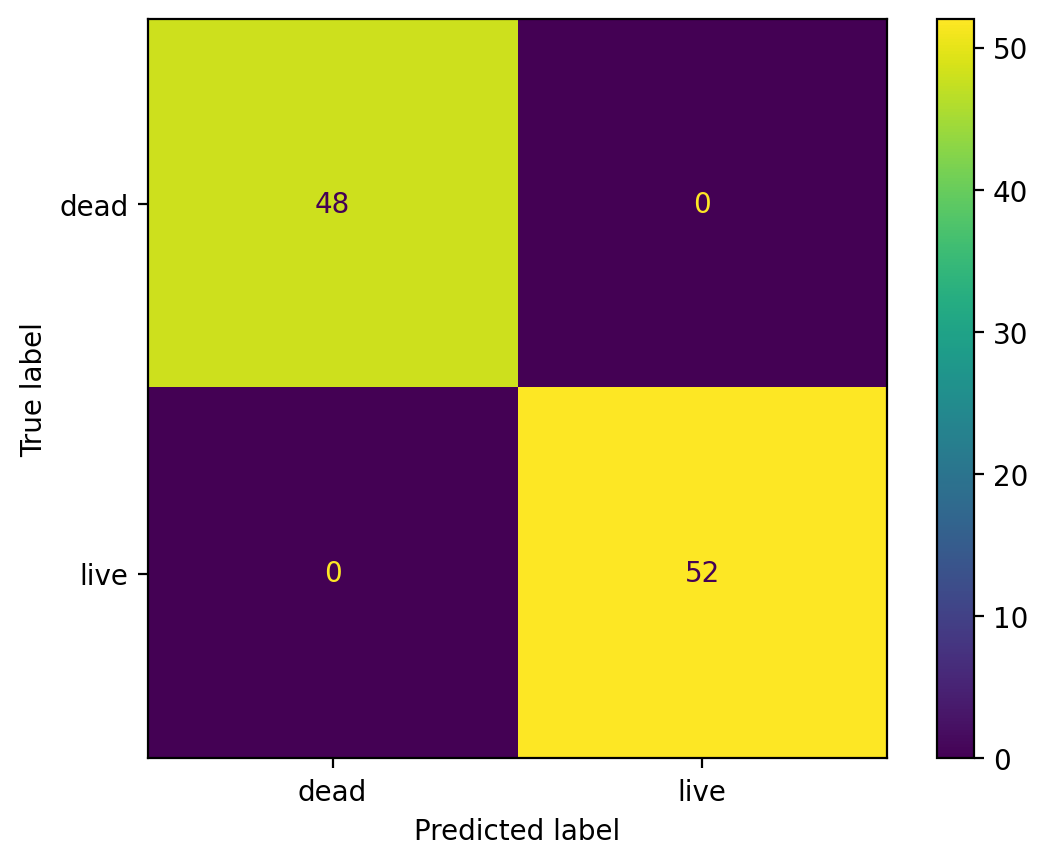

In [26]:
# Retreive predictions (LDA-transformed data) and ground truth 
predictions = kmeans_labels_lda
ground_truth = list(bbbc010_img.loc[:, 'label'])

# Compute the confusion matrix
confusion_matrix = skm.confusion_matrix(ground_truth, predictions, labels = np.unique(ground_truth))

# Visualize the result
disp = skm.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = np.unique(ground_truth))
disp.plot()

plt.show()

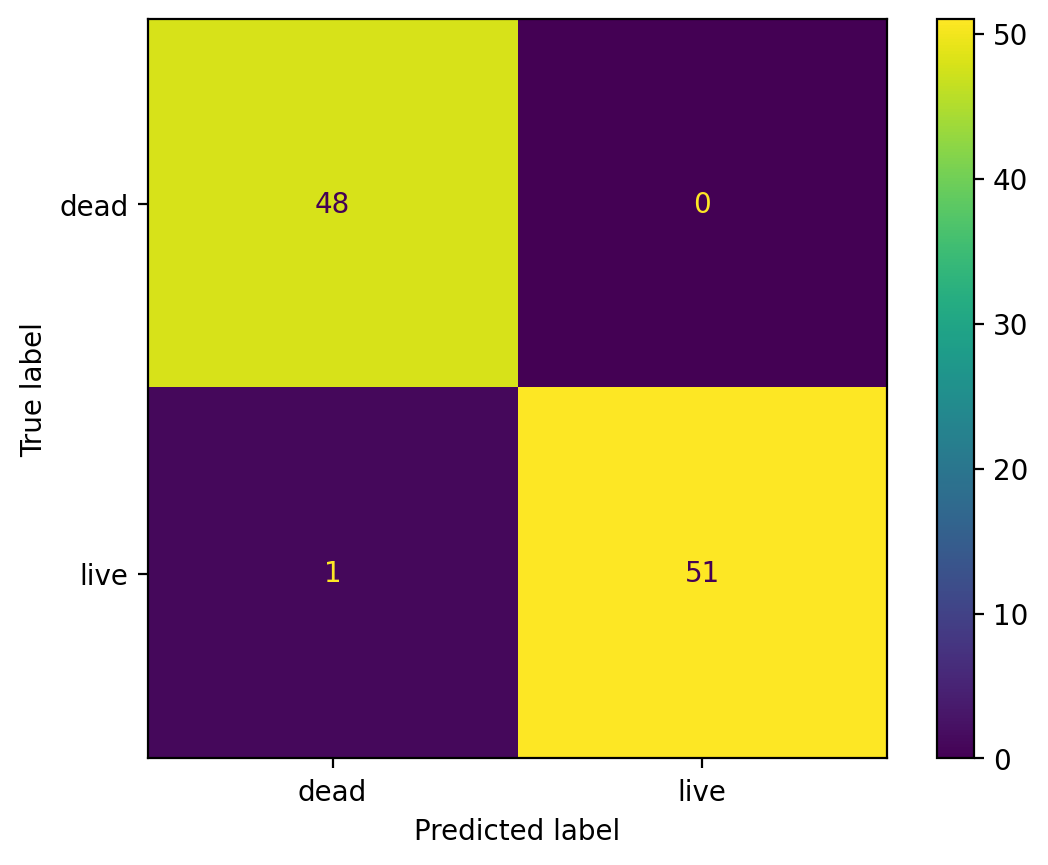

In [27]:
# Retreive predictions (PCA-transformed data, 1st PC) and ground truth
predictions = kmeans_labels_pca
ground_truth = list(bbbc010_img.loc[:, 'label'])

# Compute the confusion matrix
confusion_matrix = skm.confusion_matrix(ground_truth, predictions, labels = np.unique(ground_truth))

# Visualize the result
disp = skm.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = np.unique(ground_truth))
disp.plot()

plt.show()
# We have one live sample misclassified as dead!

**4.2** Summarizing classification performance as a single number instead of a matrix is sometimes desirable, but often difficult as no metric can captures every single aspect of a classification problem one may want to assess. A large variety of classification metrics are available depending on what one wants to focus on (https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers).

Run the lines below to compute and display a handful of classification performance metrics evaluating the quality of the labels predicted by K-means on the LDA-transformed data. Then, adapt the code to evaluate the quality of the labels predicted by K-means on the PCA-transformed data, using the 1st principal component only (see 2.6). Do you notice a difference?

In [28]:
# Retreive predictions (LDA-transformed data) and ground truth
predictions = kmeans_labels_lda
ground_truth = list(bbbc010_img.loc[:, 'label'])

# Compute a handful of classification metrics and display them
accuracy = skm.accuracy_score(ground_truth, predictions)
print('Accuracy: '+str(accuracy))

precision = skm.precision_score(ground_truth, predictions, pos_label= 'live')
print('Precision: '+str(precision))

recall = skm.recall_score(ground_truth, predictions, pos_label= 'live')
print('Recall: '+str(recall))

f1_score = skm.f1_score(ground_truth, predictions, pos_label= 'live')
print('F1 score: '+str(f1_score))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0


In [29]:
# Retreive predictions (PCA-transformed data, 1st PC) and ground truth
predictions = kmeans_labels_pca
ground_truth = list(bbbc010_img.loc[:, 'label'])

# Compute a handful of classification metrics and display them
accuracy = skm.accuracy_score(ground_truth, predictions)
print('Accuracy: '+str(accuracy))

precision = skm.precision_score(ground_truth, predictions, pos_label= 'live')
print('Precision: '+str(precision))

recall = skm.recall_score(ground_truth, predictions, pos_label= 'live')
print('Recall: '+str(recall))

f1_score = skm.f1_score(ground_truth, predictions, pos_label= 'live')
print('F1 score: '+str(f1_score))

# As we guessed already in 2.6, LDA is marginally better than the 1st PC when it comes to discriminating 
# between the two classes.

Accuracy: 0.99
Precision: 1.0
Recall: 0.9807692307692307
F1 score: 0.9902912621359222


## 5. Supervised classification

Having access to class labels, we can also explore *supervised* classification methods. These classical (i.e., not "deep") machine learning algorithms use provided labels to learn how features should be combined in order to best discriminate between classes. Once trained, they can be run in *inference mode* on unlabeled data and provide class predictions.

**5.1** A trained classifier is supposed to be able to accurately classify unseen data points, but how to assess whether it does so well enough? The trick is to split our labelled data, prior to training, into a so-called *training* and *test* sets. The data and labels of the training set are visible to the classified and used for the actual training, while the test set remains hidden during that time. Once the classifier is trained, it will have to predict labels for the test set data. These predicted labels will be compared to the known ground-truth ones, thus providing an estimation of the predictive power of the trained algorithm. 

Run the lines below to randomly split the data into a training (2/3 of the data) and test (1/3 of the data) sets. The proportion of samples kept for testing is a free parameter that usually ranges between 1/10 and 1/3.

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
# Create matrix of data and labels
X = bbbc010_img.loc[:, bbbc010_img.columns != 'label']
Y = bbbc010_img.loc[:, 'label']

# Portion of the data for the test set
split = float(1/3)

# Randomly split the data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size = split)

**5.2** Support Vector Machines (SVM, https://en.wikipedia.org/wiki/Support-vector_machine) is a family of classical machine learning algorithms that attempts at finding separation between classes as hyperplanes that are as far as possible to the data points. This is done by maximizing the length of the vector from the closest data point that is orthogonal to the class separation boundary, which is referred to as *support vector* and gives the algorithm its name. 

While the technical details of SVM are out of the scope of this course, we can get a feel for the power of this approach if we try to classify our data as they were originally, without applying any feature selection or dimensionality reduction method. Run the lines below to train a linear SVM on the training set and use it to predict the labels of the test set. How does it look?

In [32]:
from sklearn import svm

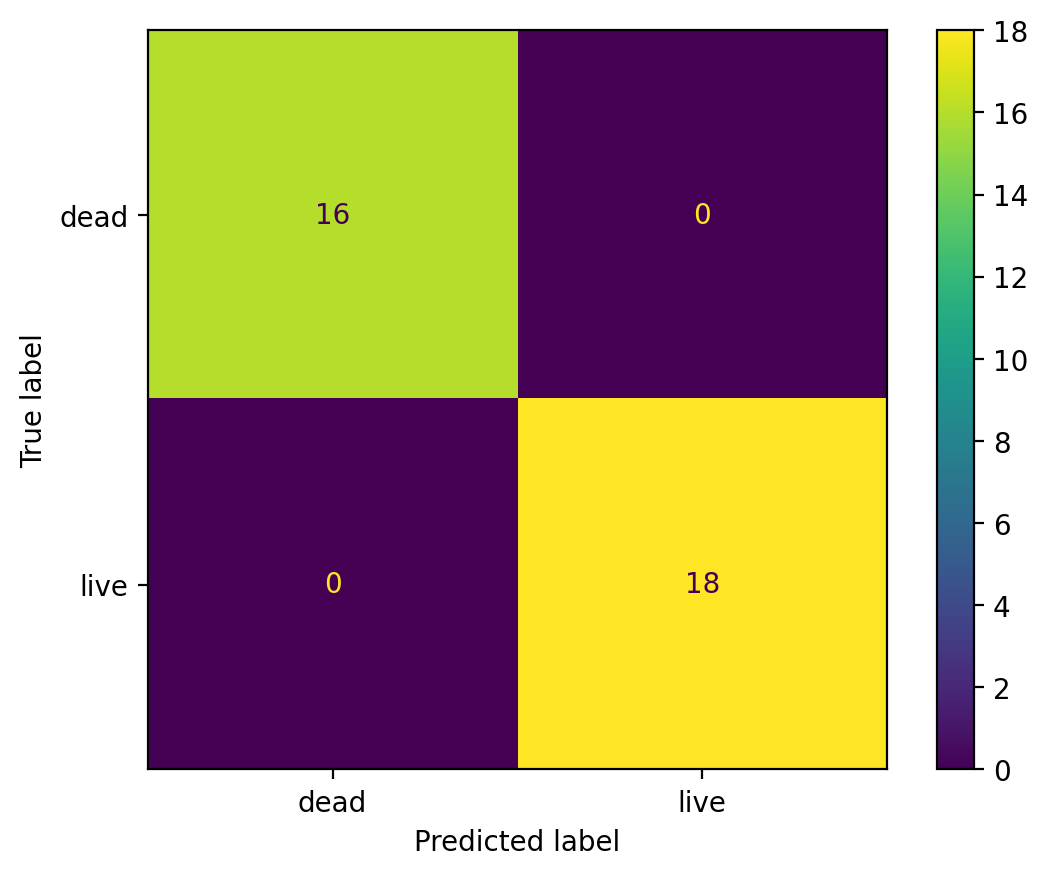

In [33]:
# Create matrix of data and labels
X = train_data
Y = train_labels

# Train a linear SVM on the training set
classifier = svm.SVC()
classifier.fit(X, Y)

# Predict labels on the test set
pred_labels = classifier.predict(test_data)

# Compute the confusion matrix
confusion_matrix = skm.confusion_matrix(test_labels, pred_labels, labels = np.unique(test_labels))

# Visualize the result
disp = skm.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = np.unique(test_labels))
disp.plot()

plt.show()
# A perfect classification result!

**5.3** To compare against SVM, let's try and see how K-means would have fared if it had to deal with the original feature matrix. Adapt the code from 3.1 and 4.1 to run K-means on the whole dataset without dimensionality reduction, and compare with both the K-means result you obtained in 4.1 and the SVM result you obtained in 5.2. What do you notice?

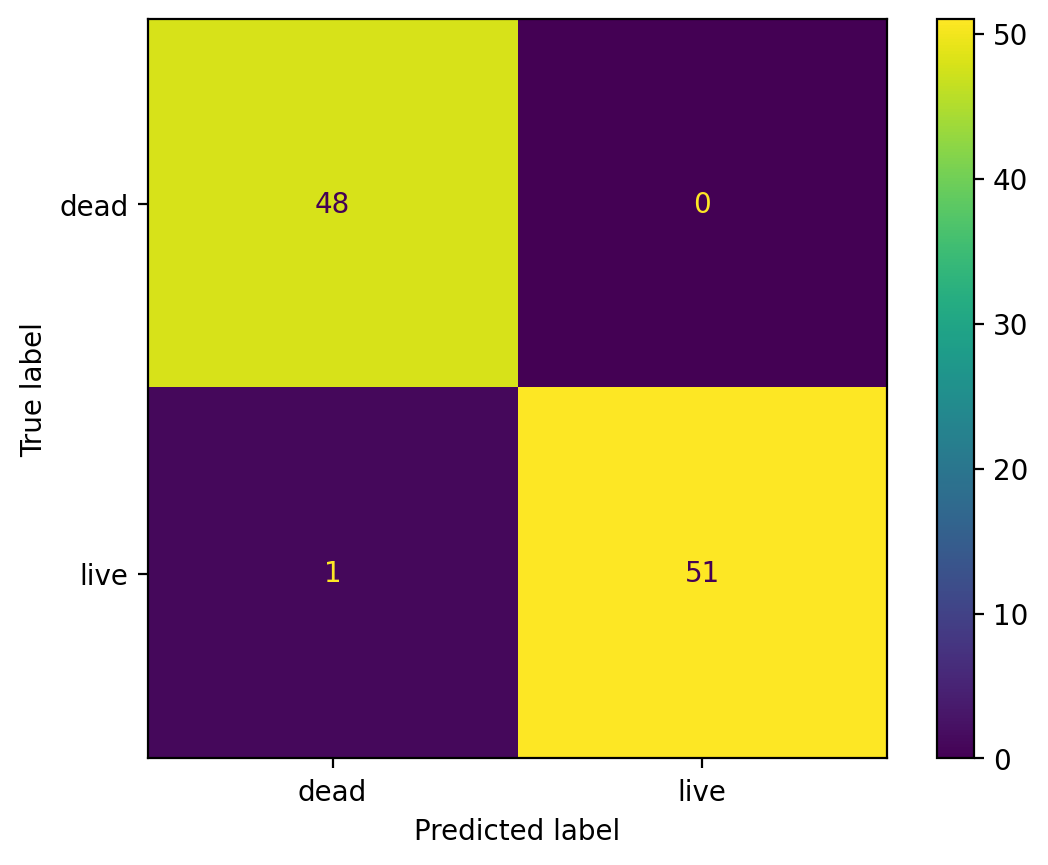

In [34]:
# There are (still!) two classes in this dataset
K = 2

# Create matrix of data and labels
X = bbbc010_img.loc[:, bbbc010_img.columns != 'label']
Y = bbbc010_img.loc[:, 'label']

# Perform K-means on the test data
kmeans = KMeans(n_clusters=K, random_state=5)
kmeans.fit(X)

# Retreive the cluster label and display it
kmeans_labels = kmeans.predict(X)

predictions = np.empty((len(kmeans_labels)), dtype='object')
predictions[kmeans_labels == 1] = 'live'
predictions[kmeans_labels == 0] = 'dead'

# Compute the confusion matrix
confusion_matrix = skm.confusion_matrix(Y, predictions, labels = np.unique(Y))

# Visualize the result
disp = skm.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = np.unique(Y))
disp.plot()

plt.show()
# We are making one mistake when skipping dimensionality reduction with K-means!

**5.4** Another popular classical supervised machine learning algorithm is decision trees (https://en.wikipedia.org/wiki/Decision_tree). Decision trees, as their name imply, perform classification by identifying sequences of logical rules to be followed in order to decide which class a sample should be assigned to. In addition to being extremely fast to train, like SVM, decision trees have the interesting property of being fully interpretable. Random forests, as used in ilastik's pixel classification workflow for segmentation (https://www.ilastik.org/), are based on decision trees.

Run the code below to 1) train a decision tree on the training set and retreive predictions on the test set, and 2) visualize the decision tree. Based on this, can you identify which feature(s) is(are) used to decide on the class?

In [35]:
from sklearn import tree

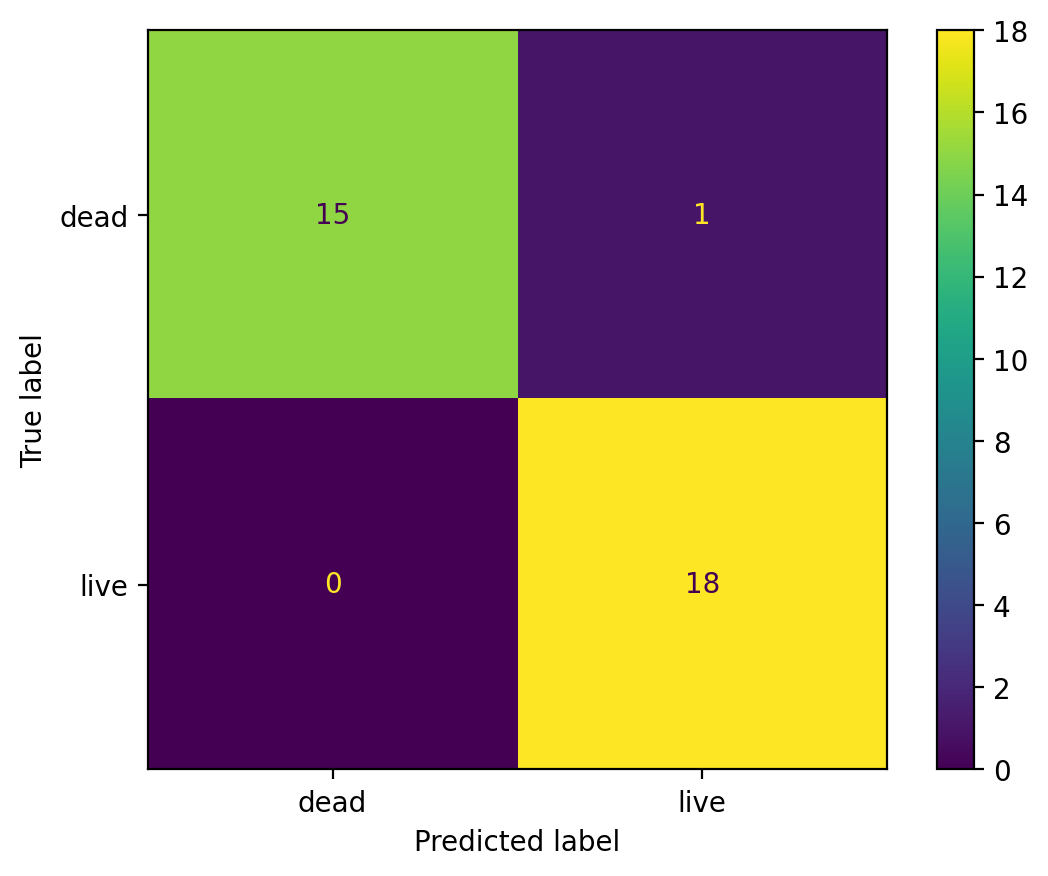

In [36]:
# Create matrix of data and labels
X = train_data
Y = train_labels

# Train decision tree on the training set
classifier = tree.DecisionTreeClassifier()
classifier.fit(X, Y)

# Retreive predictions on the test set
pred_labels = classifier.predict(test_data)

# Compute the confusion matrix
confusion_matrix = skm.confusion_matrix(test_labels, pred_labels, labels = np.unique(test_labels))

# Visualize the result
disp = skm.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = np.unique(test_labels))
disp.plot()

plt.show()
# An almost-perfect classification result!

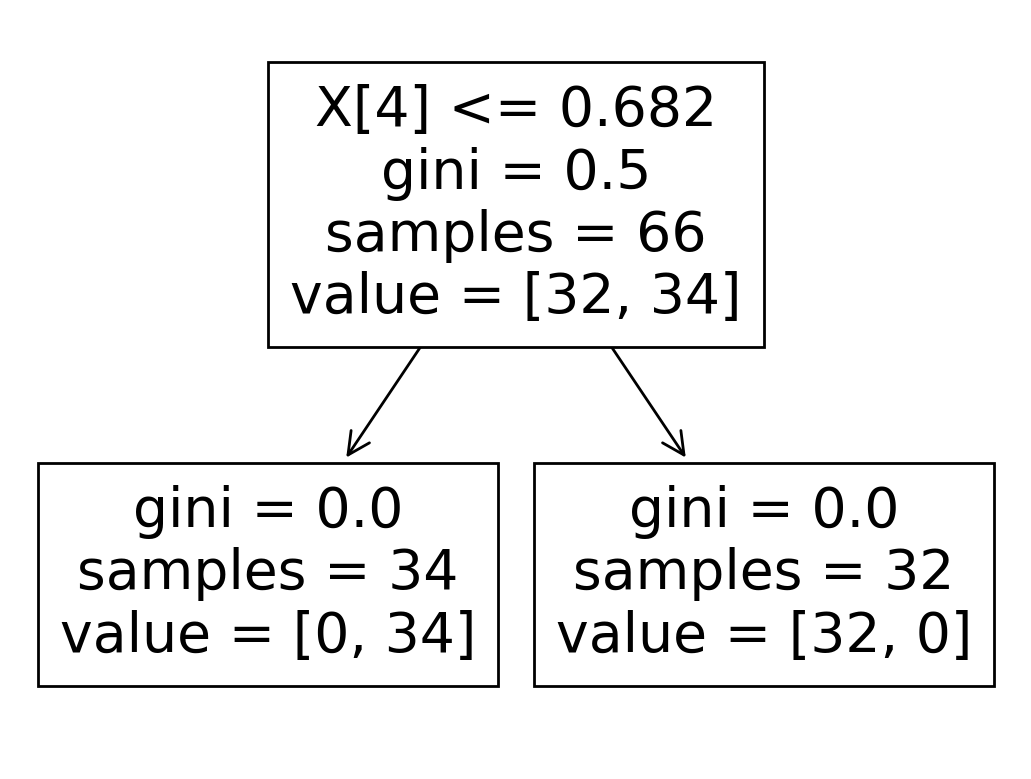

In [37]:
# Visualize the decision tree
tree.plot_tree(classifier)

plt.show()

In [38]:
# Display the feature used for decision (X[n])
train_data.columns[4]

'axis_major_length'

**5.5** The decision tree you trained in 5.4 provides you with a feature and a threshold to classify the data. Try to write a piece of code that assigns class labels by manually thresholding that one feature identified by the decision trees, and check the result. Does that work?

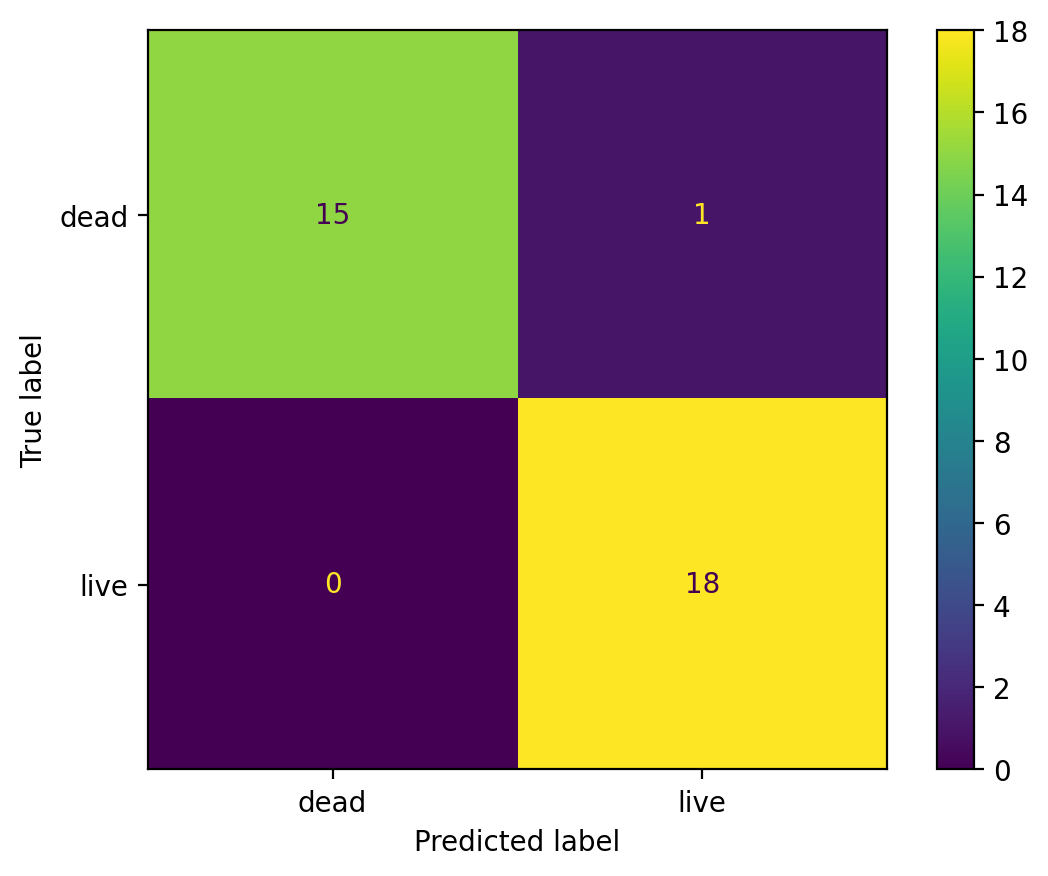

In [40]:
thresh = 0.682
index = 4

X = test_data.loc[:, train_data.columns[index]]

predictions = np.empty((len(X)), dtype='object')
predictions[X<=thresh]= 'live'
predictions[X>thresh]= 'dead'

# Retreive predictions (PCA-transformed data, 1st PC) and ground truth
ground_truth = test_labels

# Compute the confusion matrix
confusion_matrix = skm.confusion_matrix(ground_truth, predictions, labels = np.unique(ground_truth))

# Visualize the result
disp = skm.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = np.unique(ground_truth))
disp.plot()

plt.show()
# As expected, we get the same result as the decision tree. The decision tree has thus helped us identify a 
# single feature that allows discriminating strongly between our two classes, and a threshold we can use for
# that purpose.

## BONUS. Classifying individual objects

If you like challenges, apply everything you've seen up to now to try and classify individual *C. elegans* worms in the dataset instead of whole images.

**6.1** Run the lines below to load and display the feature matrix for the entire BBBC010 dataset. This time, features are reported for individual object instances.

In [41]:
bbbc010_obj_feats = pd.read_csv('data/Part 4/BBBC010/bbbc010_object_features.csv')
bbbc010_obj_feats.set_index('instance_id', inplace = True)

display(bbbc010_obj_feats)

,area,area_bbox,area_convex,area_filled,axis_major_length,axis_minor_length,eccentricity,equivalent_diameter_area,euler_number,extent,...,moments_weighted_hu-2,moments_weighted_hu-3,moments_weighted_hu-4,moments_weighted_hu-5,moments_weighted_hu-6,perimeter,perimeter_crofton,solidity,inertia_tensor_eigvals-0,inertia_tensor_eigvals-1
instance_id,,,,,,,,,,,,,,,,,,,,,
B19_14,902,5168,1017,902,103.543142,11.616397,0.993687,33.888967,1,0.174536,...,23940.345921,19475.162046,4.203367e+08,1.511937e+06,-1.241909e+07,215.705627,207.183275,0.886922,670.073886,8.433792
B19_14,892,6248,1048,892,119.446128,9.930965,0.996538,33.700589,1,0.142766,...,2535.212490,1829.380476,3.933488e+06,1.364230e+05,-2.211612e+05,236.090404,226.509255,0.851145,891.711088,6.164004
B19_14,1073,2356,1264,1073,132.409286,10.895316,0.996609,36.961954,1,0.455433,...,34302.045488,33058.033002,1.113206e+09,2.363752e+06,-7.176924e+05,265.740115,254.618944,0.848892,1095.763693,7.419245
B19_14,870,3780,1087,870,114.346205,10.926564,0.995424,33.282404,1,0.230159,...,8654.502748,3454.043512,1.760087e+07,1.579022e+05,-6.844388e+06,239.994949,230.603696,0.800368,817.190906,7.461862
B19_14,969,7569,1098,969,127.694970,9.925922,0.996974,35.125050,1,0.128022,...,7172.795870,7184.270060,5.157250e+07,4.813559e+05,-4.276454e+03,255.924928,245.509912,0.882514,1019.125338,6.157746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A01_15,799,1408,1092,799,46.779707,34.087398,0.684855,31.895429,-1,0.567472,...,739.318118,20.898658,-1.294405e+02,2.005234e+01,-2.594499e+03,205.758405,198.964503,0.731685,136.771310,72.621921
B01_07,978,4305,1410,978,116.127593,13.314544,0.993405,35.287792,1,0.227178,...,11175.911702,9020.480529,9.053035e+07,5.652779e+05,2.691117e+06,246.409163,236.292052,0.693617,842.851118,11.079817
C10_10,1069,1710,1345,1069,120.147486,12.942310,0.994181,36.892995,1,0.625146,...,54144.930588,41022.308572,1.931240e+09,3.362168e+06,-9.015857e+07,242.911688,232.976238,0.794796,902.213649,10.468962


**6.2** Run the lines below to load and display the ground truth label for each instance in the dataset.

In [42]:
bbbc010_obj_gt = pd.read_csv('data/Part 4/BBBC010/bbbc010_object_ground_truth.csv')
bbbc010_obj_gt.set_index('instance_id', inplace = True)

display(bbbc010_obj_gt)

,label
instance_id,
B19_14,dead
C08_03,live
A19_06,dead
A17_08,dead
C14_13,dead
...,...
A01_15,live
B01_07,live
C10_10,live


**6.3** Classify individual worms in the dataset as "dead" or "live", and report the performance of your solution using appropriate metrics. 

In [43]:
# This is a challenge, no solution given here :) 

**6.4** Based on your classification results, identify images that contain a mix of dead and live worms. Relating your observations with the whole-image label they had in bbbc010_img_gt (1.3), would you say that these images were mislabeled? Why?

In [44]:
# This is a challenge, no solution given here :) 